***
***

<img width="220" align="right" alt="Screen Shot 2020-10-14 at 20 48 36" src="https://user-images.githubusercontent.com/8030363/96350526-7d09a680-1073-11eb-9e45-a510c496bcc1.png">


# OMOP2OBO

### *Ontologizing Health Systems at Scale: Making Translational Discovery a Reality*

<br>

**Author:** [TJCallahan](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=callahantiff@gmail.com)  
**GitHub Repository:** [OMOP2OBO](https://github.com/callahantiff/OMOP2OBO/wiki) ([`V1.0`](https://github.com/callahantiff/OMOP2OBO/wiki/v1.0))  
**Analysis Dates:** `10/16/2020`

<br>

***
***

### Notebook Objective   
The purpose of this notebook is to present the results for the preliminary manuscript describing the `OMOP2OBO` algorithm and mappings. For this analysis, each clinical concepts from several domains (i.e. Conditions, Drug Ingredients, and Measurements) will separately analyzed with respect to the specific Open Biomedical Ontologies (OBO) it was mapped to. The analysis is presented in the order of the mapping algorithm workflow, which is shown below. Additional information on each of the steps shown in this figure, with respect to the analyses performed in this notebook, are provided below. 

<img width="2000" alt="Screen Shot 2020-09-20 at 22 59 00" src="https://user-images.githubusercontent.com/8030363/96931469-99924e00-147a-11eb-9c19-fe5a95786772.png">

**Step 1: Concept Alignment**  
This section describes the results generated from performing exact alignment between `OMOP` concept source codes and ontology concept database cross-references (i.e. dbXRefs) as well as `OMOP` concept labels and synonyms to ontology concept labels and synonyms. Done for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept- and ancestor-level. 


**Step 2: Concept Embedding**  
This section describes the results from creating embeddings using a Bag-of-Words + TF-IDF vector space model. This model was created using `OMOP` concept labels and synonyms and ontology concept labels and synonyms. To retrieve mappings from this model, a cosine similarity score was calculated between all clinical and ontology concepts. Only those mappings that were greater than a cut-off threshold (<u>></u>`0.25` for drug ingredients and medications and <u>></u>`0.20` for conditions) and within the top 75% of the distribution of scores were kept. This is performed for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept-level.


**Step 3: Manual Annotation**  
This section describes the results obtained from manual annotation. Performed only on `Concepts used in Practice` at the concept-level.


**Step 4: Final Mapping**
The final set of mappings will be presented. This will include descriptions of mappings by mapping category as well as what level (i.e. concept, ancestor) mappings were created.


**Validation**  
This section describes results from three different types of validation designed to assess the accuracy, generalizability, and consistency of the final mapping set.


***
## Table of Contents <a class="anchor" id="toc"></a>
***

This notebook divides the analysis into two components: (1) summarization of mapping results and (2) validation of mapping results. 

* [Ontology Data](#ontology-data)  
* [Mapping Results](#mapping-results)  
* [Mapping Validation](#mapping-validation)   
  - [Domain Expert Review](#expert-review)  
  - [Coverage Study](#coverage-study)  
  - [Logical Validation](#logical-eval)  

***
***

<br>

## Set-up Environment
***

In [1]:
# import needed libraries
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
import urllib.request
import warnings

from collections import Counter
from datetime import date, datetime
from itertools import combinations
from more_itertools import unique_everseen
from scipy.stats import chi2, chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests

from analytic_utils import *

# set time-stamped var for writing output to
date_today = '_' + datetime.strftime(datetime.strptime(str(date.today()), '%Y-%m-%d'), '%d%b%Y').upper()


### Data 

There are several data files needed for this analysis. Each needed data source is described in the table below and can be accessed directly by clicking on the hyperlinked file name. 

Data | Data Type | Description | File  
:--: | :--: | :-- | --  
Condition Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Condition_Occurrence_Mapping_Full_Oct2020.xlsx`
Drug Ingredient Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Drug_Exposure_Mapping_Full_Oct2020.xlsx`  
Measurement Concept Mappings | `Mapping Data` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Measurement_Mapping_Subset_Oct2020.xlsx`  
Clinical Concept Frequency | `Mapping Data` | A `csv` file containing metadata for the condition, drug_exposure, and measurement codes utilized in practice. The sheet includes data describing the number of visits and people that have utilized each concept as well as the total number of times the concept was used in practice | `OMOP2OBO_2020_COMOP2OBO_Coverage_Counts.csv` 
Ontology Metadata Dictionary | `Ontology Data` | A pickled dictionary that contains a separate dictionary fro each ontology, where the inner keys of the dictionaries for each ontology contains information on: labels, definitions, synonyms, synonym types, and dbXRefs | `master_ontology_dictionary.pickle`  
Expert Mapping Validation | `Validation Data` | An Excel Workbook containing a separate sheet for each mapping set that received expert review:<br>(1) Conditions_AprJul2019;<br>(2) Drugs_FebApr2019;<br>(3) Labs_JanMar2019;<br>(4) LabsSurvey_Oct2018Jan2019 | `OMOP2OBO_V1.0_Validation_Subset_Oct2020.xlsx`
Concept Prevalence Data | `Validation Data` | An Excel Workbook containing several sheets that store modified concept prevalence data: (1) Database_Summary;<br>(2) Database_Domain_Count;<br>(3) Condition_Occurence_Concepts;<br>(4) Drug_Exposure_Concepts;<br>(5) Measurement_Concepts | `ConceptPrevalenceTiffany_OHDSI_Sep2020_FULL.xlsx`   

<br>

*NOTE.* All of the `Mapping Data` and `Ontology Data` are available directly for download via Zenodo (ADD LINK HERE)[]. The `Clinical Concept Frequency` and all `Validation Data` contain some private institutional data and thus are not publicly available at this time. If you are interested in any of these data sources, please email Tiffany Callahan (`callahantiff@gmail.com`).

### Global Variables

In [2]:
# create global variables to store data urls
# clinical data to use for mapping
conditions = '<<file_path>>'
medications = '<<file_path>>'
measurments = '<<file_path>>'

# mapping data
conds_mapping_url = '<<>URL>>'
meds_mapping_url = '<<>URL>>'
labs_mapping_url = '<<>URL>>'

# concept frequencies
chco_concept_freq_url = '<<>URL>>'

# ontology data
# processed_ontology_data = '<<>URL>>'
ontology_metadata = ['label', 'dbxref', 'synonym', 'synonym_type']

# create global variables to store ontologies by clinical domain
condition_onts = ['HP', 'MONDO']  
ingredient_onts = ['CHEBI', 'PR', 'NCBITaxon', 'VO']
measurement_onts = ['HP', 'CHEBI', 'CL', 'UBERON', 'PR', 'NCBITaxon']  

# validation data
expert_validation = '<<>URL>>' 
coverage_data = '<<>URL>>'

# silencing warnings
warnings.filterwarnings('ignore')


In [3]:
# set plotting arguments
%matplotlib inline
plt.style.use('ggplot')

# color palette
my_pal = {'HP': 'mediumpurple',
          'MONDO': 'cadetblue',
          'UBERON': 'gold',
          'VO': 'rebeccapurple',
          'PR': 'darkorange',
          'NCBI': 'mediumturquoise',
          'CL': 'hotpink',
          'CHEBI': 'limegreen'}


<br>

***
## Ontology Data <a class="anchor" id="ontology-data"></a>
***  

This section is designed to provide an overview of the ontology data available when creating mappings. Each ontologies, shown below by clinical domain, were downloaded on `September 14, 2020`. For each ontology, only current (non-deprecated) classes were considered were eligible for mapping. For all current classes, each ontology was queried to obtain class universal resource identifiers (URI), labels, definitions, synonyms (including synonym type), and database cross-references (dbXRefs).  

Ontology | Clinical Domain 
:--: | :--:
[Human Phenotype Ontology (hp)](http://purl.obolibrary.org/obo/hp.owl) | Conditions; Measurements      
[Mondo Disease Ontology (mondo)](http://purl.obolibrary.org/obo/mondo.owl) | Conditions      
[Cell Ontology (cl)](http://purl.obolibrary.org/obo/cl.owl) | Measurements        
[Chemical Entities of Biological Interest (chebi)](http://purl.obolibrary.org/obo/chebi.owl) | Drugs; Measurements           
[NCBI Organism Taxonomy (ncbitaxon)](http://purl.obolibrary.org/obo/ncbitaxon.owl) | Drugs; Measurements     
[Protein Ontology (pr)](http://purl.obolibrary.org/obo/pr.owl) | Drugs; Measurements        
[Uber Anatomy Ontology (uberon)](http://purl.obolibrary.org/obo/uberon/ext.owl) | Measurements       
[Vaccine Ontology (vo)](http://purl.obolibrary.org/obo/vo.owl) | Drugs  


In [8]:
# load ontology data
ont_data = pickle.load(urllib.request.urlopen(processed_ontology_data))

# filter and process ontology data
processed_ont_info = outputs_ontology_metadata(ont_data, list(ont_data.keys()), ontology_metadata)

*Human Phenotype Ontology (HPO)*  
The `HP` ontology contained `15,247` labeled classes, `19,569` dbXRefs, and `19,860` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [9]:
hp_label, hp_dbxref = processed_ont_info['hp']['label'], processed_ont_info['hp']['dbxref']
hp_synonym, hp_synonym_type = processed_ont_info['hp']['synonym'], processed_ont_info['hp']['synonym_type']

print('There are {} HP class labels'.format(hp_label),
      '\nThere are {} HP class dbXRefs'.format(hp_dbxref),
      '\nThere are {} HP class synonyms of type: {}'.format(hp_synonym, hp_synonym_type))

There are 15247 HP class labels 
There are 19569 HP class dbXRefs 
There are 19860 HP class synonyms of type: hasBroadSynonym, hasExactSynonym, hasNarrowSynonym, hasRelatedSynonym


*Mondo Disease Ontology (MONDO)*  
The `MONDO` ontology contained `22,288` labeled classes, `159,918` dbXRefs, and `98,181` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, `hasBroadSynonym`, and `excluded_synonym`.

In [10]:
mondo_label, mondo_dbxref = processed_ont_info['mondo']['label'], processed_ont_info['mondo']['dbxref']
mondo_synonym, mondo_synonym_type = processed_ont_info['mondo']['synonym'], processed_ont_info['mondo']['synonym_type']

print('There are {} MONDO class labels'.format(mondo_label),
      '\nThere are {} MONDO class dbXRefs'.format(mondo_dbxref),
      '\nThere are {} MONDO class synonyms of type: {}'.format(mondo_synonym, mondo_synonym_type))

There are 22288 MONDO class labels 
There are 159918 MONDO class dbXRefs 
There are 98181 MONDO class synonyms of type: hasExactSynonym, hasRelatedSynonym, excluded_synonym, hasNarrowSynonym, hasBroadSynonym


*Chemical Entities of Biological Interest (CHEBI)*  
The `CHEBI` ontology contained `126,169` labeled classes, `231,247` dbXRefs, and `269,798` synonyms of type `hasExactSynonym` and `hasRelatedSynonym`.

In [11]:
chebi_label, chebi_dbxref = processed_ont_info['chebi']['label'], processed_ont_info['chebi']['dbxref']
chebi_synonym, chebi_synonym_type = processed_ont_info['chebi']['synonym'], processed_ont_info['chebi']['synonym_type']

print('There are {} CHEBI class labels'.format(chebi_label),
      '\nThere are {} CHEBI class dbXRefs'.format(chebi_dbxref),
      '\nThere are {} CHEBI class synonyms of type: {}'.format(chebi_synonym, chebi_synonym_type))

There are 126169 CHEBI class labels 
There are 231247 CHEBI class dbXRefs 
There are 269798 CHEBI class synonyms of type: hasExactSynonym, hasRelatedSynonym


*Cell Ontology (CL)*  
The `CL` ontology contained `2,238` labeled classes, `1,376` dbXRefs, and `2,124` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [12]:
cl_label, cl_dbxref = processed_ont_info['cl']['label'], processed_ont_info['cl']['dbxref']
cl_synonym, cl_synonym_type = processed_ont_info['cl']['synonym'], processed_ont_info['cl']['synonym_type']

print('There are {} CL class labels'.format(cl_label),
      '\nThere are {} CL class dbXRefs'.format(cl_dbxref),
      '\nThere are {} CL class synonyms of type: {}'.format(cl_synonym, cl_synonym_type))

There are 2238 CL class labels 
There are 1376 CL class dbXRefs 
There are 2124 CL class synonyms of type: hasBroadSynonym, hasExactSynonym, hasNarrowSynonym, hasRelatedSynonym


*NCBI Taxonomy (NCBITaxon)*  
The `NCBITaxon` ontology contained `2,241,110` labeled classes, `18,426` dbXRefs, and `263,571` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, and `hasBroadSynonym`.

In [13]:
ncbitaxon_label, ncbitaxon_dbxref = processed_ont_info['ncbitaxon']['label'], processed_ont_info['ncbitaxon']['dbxref']
ncbitaxon_synonym, ncbitaxon_synonym_type = processed_ont_info['ncbitaxon']['synonym'], processed_ont_info['ncbitaxon']['synonym_type']

print('There are {} NCBITaxon class labels'.format(ncbitaxon_label),
      '\nThere are {} NCBITaxon class dbXRefs'.format(ncbitaxon_dbxref),
      '\nThere are {} NCBITaxon class synonyms of type: {}'.format(ncbitaxon_synonym, ncbitaxon_synonym_type))

There are 2241110 NCBITaxon class labels 
There are 18426 NCBITaxon class dbXRefs 
There are 263571 NCBITaxon class synonyms of type: hasBroadSynonym, hasExactSynonym, hasRelatedSynonym


*Vaccine Ontology (VO)*  
The `VO` ontology contained `5,789` labeled classes, `0` dbXRefs, and `6` synonyms of type `hasSynonym`.

In [14]:
vo_label, vo_dbxref = processed_ont_info['vo']['label'], processed_ont_info['vo']['dbxref']
vo_synonym, vo_synonym_type = processed_ont_info['vo']['synonym'], processed_ont_info['vo']['synonym_type']

print('There are {} VO class labels'.format(vo_label),
      '\nThere are {} VO class dbXRefs'.format(vo_dbxref),
      '\nThere are {} VO class synonyms of type: {}'.format(vo_synonym, vo_synonym_type))

There are 5789 VO class labels 
There are 0 VO class dbXRefs 
There are 6 VO class synonyms of type: hasSynonym


*Uber-Anatomy Ontology (UBERON)*  
The `UBERON` ontology contained `13,898` labeled classes, `51,322` dbXRefs, and `36,771` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [15]:
uberon_label, uberon_dbxref = processed_ont_info['uberon']['label'], processed_ont_info['uberon']['dbxref']
uberon_synonym, uberon_synonym_type = processed_ont_info['uberon']['synonym'], processed_ont_info['uberon']['synonym_type']

print('There are {} UBERON class labels'.format(uberon_label),
      '\nThere are {} UBERON class dbXRefs'.format(uberon_dbxref),
      '\nThere are {} UBERON class synonyms of type: {}'.format(uberon_synonym, uberon_synonym_type))

There are 13898 UBERON class labels 
There are 51322 UBERON class dbXRefs 
There are 36771 UBERON class synonyms of type: hasBroadSynonym, hasExactSynonym, hasNarrowSynonym, hasRelatedSynonym


*Protein Ontology (PRO)*  
The `PR` ontology contained `215,624` labeled classes, `195,671` dbXRefs, and `590,190` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [16]:
pr_label, pr_dbxref = processed_ont_info['pr']['label'], processed_ont_info['pr']['dbxref']
pr_synonym, pr_synonym_type = processed_ont_info['pr']['synonym'], processed_ont_info['pr']['synonym_type']

print('There are {} PR class labels'.format(pr_label),
      '\nThere are {} PR class dbXRefs'.format(pr_dbxref),
      '\nThere are {} PR class synonyms of type: {}'.format(pr_synonym, pr_synonym_type))

There are 215624 PR class labels 
There are 195671 PR class dbXRefs 
There are 590190 PR class synonyms of type: hasBroadSynonym, hasExactSynonym, hasNarrowSynonym, hasRelatedSynonym


*Plot Metadata Attribute Counts by Ontology*

In [17]:
# create grouped DataFrame
ont_list = list(unique_everseen(condition_onts + ingredient_onts + measurement_onts))
ontologies = [x for y in [[x] * 3 for x in ont_list] for x in y]
counts = [math.log10(hp_label), math.log10(hp_dbxref), math.log10(hp_synonym),
          math.log10(mondo_label), math.log10(mondo_dbxref), math.log10(mondo_synonym),
          math.log10(chebi_label), math.log10(chebi_dbxref), math.log10(chebi_synonym),
          math.log10(cl_label), math.log10(cl_dbxref), math.log10(cl_synonym),
          math.log10(ncbitaxon_label), math.log10(ncbitaxon_dbxref), math.log10(ncbitaxon_synonym),
          math.log10(vo_label), vo_dbxref, math.log10(vo_synonym),
          math.log10(uberon_label), math.log10(uberon_dbxref), math.log10(uberon_synonym),
          math.log10(pr_label), math.log10(pr_dbxref), math.log10(pr_synonym)]

ontology_counts = pd.DataFrame({'ontology': ontologies,
                                'metadata': ontology_metadata[:-1] * 8,
                                'counts': counts})

ontology_counts.head()

,ontology,metadata,counts
0,HP,label,4.183184
1,HP,dbxref,4.291569
2,HP,synonym,4.297979
3,MONDO,label,4.348071
4,MONDO,dbxref,5.203897


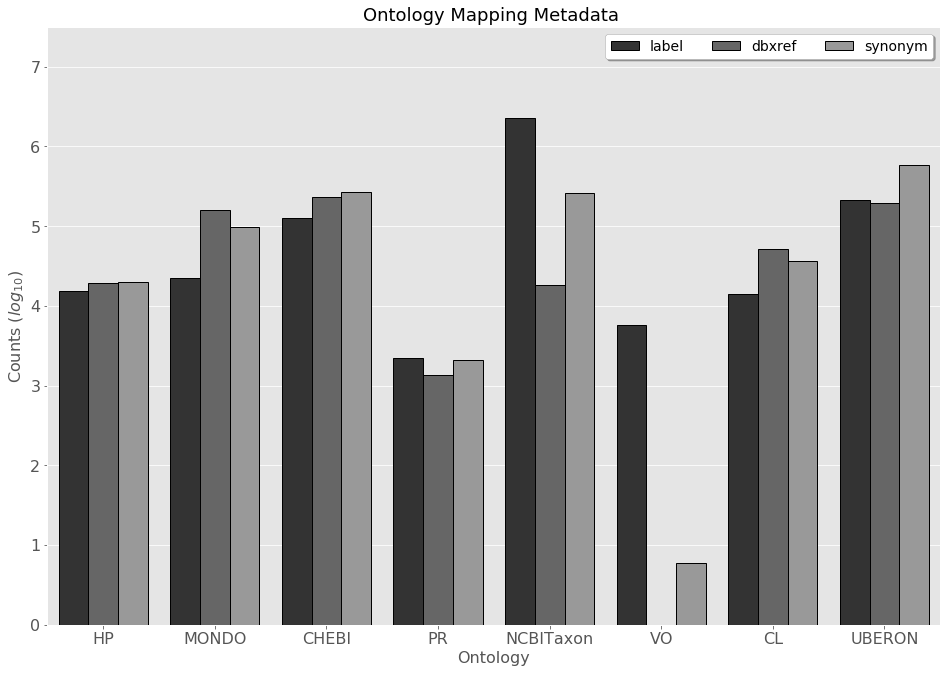

In [18]:
# generate bar plot
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

g = sns.barplot(data=ontology_counts, x='ontology', y='counts', hue="metadata",
                palette=sns.color_palette('gray', 4), edgecolor='black', linewidth=1)

# set plot label information
plt.ylim(0, 7.5)
plt.title('Ontology Mapping Metadata ', fontsize=18)
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Counts ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(title='', fontsize=14, title_fontsize=14,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)

plt.show()


**Chi-Square Test**  
A Chi-Square test of independence was run to determine if the amount of metadata available differed by ontology. First, an omnibus test was run to determine whether there was a significant relationship between the metadata and ontologies. Results from this test (with Yate's correction) revealed a significant association between the ontology metadata and ontology type ($X^{2}(14)=2,664,853.817$, $p<0.0001$). In order to better understand these findings, post-hoc tests were run using a Bonferroni adjustment to correct for multiple comparisons. These tests confirmed all ontologies had significantly different distributions of metadata ($ps<0.0001$).


In [19]:
# create grouped DataFrame
ontology_df = pd.DataFrame({'ontology': list(unique_everseen(condition_onts + ingredient_onts + measurement_onts)),
                            'label': [hp_label, mondo_label, chebi_label, cl_label, ncbitaxon_label, vo_label, uberon_label, pr_label],
                            'dbxref': [hp_dbxref, mondo_dbxref, chebi_dbxref, cl_dbxref, ncbitaxon_dbxref, vo_dbxref, uberon_dbxref, pr_dbxref],
                            'synonym': [hp_synonym, mondo_synonym, chebi_synonym, cl_synonym, ncbitaxon_synonym, vo_synonym, uberon_synonym, pr_synonym]})

ontology_df

,ontology,label,dbxref,synonym
0,HP,15247,19569,19860
1,MONDO,22288,159918,98181
2,CHEBI,126169,231247,269798
3,PR,2238,1376,2124
4,NCBITaxon,2241110,18426,263571
5,VO,5789,0,6
6,CL,13898,51322,36771
7,UBERON,215624,195671,590190


In [20]:
# reformat data so a contingency table can be created
# labels
ont_label = pd.DataFrame({'ontology': ['HP'] * hp_label + ['MONDO'] * mondo_label + ['CHEBI'] * chebi_label + ['CL'] * cl_label + ['NCBITaxon'] * ncbitaxon_label + ['VO'] * vo_label + ['UBERON'] * uberon_label + ['PR'] * pr_label,
                            'metadata': list(ont_data['hp']['label'].keys()) +
                                     list(ont_data['mondo']['label'].keys()) +
                                     list(ont_data['chebi']['label'].keys()) +
                                     list(ont_data['cl']['label'].keys()) +
                                     list(ont_data['ncbitaxon']['label'].keys()) +
                                     list(ont_data['vo']['label'].keys()) +
                                     list(ont_data['uberon']['label'].keys()) +
                                     list(ont_data['pr']['label'].keys())})
ont_label['metadata_type'] = ['label'] * len(ont_label)
ont_label.head()

# synonyms
ont_synonym = pd.DataFrame({'ontology': ['HP'] * hp_synonym + ['MONDO'] * mondo_synonym + ['CHEBI'] * chebi_synonym + ['CL'] * cl_synonym + ['NCBITaxon'] * ncbitaxon_synonym + ['VO'] * vo_synonym + ['UBERON'] * uberon_synonym + ['PR'] * pr_synonym,
                            'metadata': list(ont_data['hp']['synonym'].keys()) +
                                     list(ont_data['mondo']['synonym'].keys()) +
                                     list(ont_data['chebi']['synonym'].keys()) +
                                     list(ont_data['cl']['synonym'].keys()) +
                                     list(ont_data['ncbitaxon']['synonym'].keys()) +
                                     list(ont_data['vo']['synonym'].keys()) +
                                     list(ont_data['uberon']['synonym'].keys()) +
                                     list(ont_data['pr']['synonym'].keys())})
ont_synonym['metadata_type'] = ['synonym'] * len(ont_synonym)

# dbxref
ont_dbxref = pd.DataFrame({'ontology': ['HP'] * hp_dbxref + ['MONDO'] * mondo_dbxref + ['CHEBI'] * chebi_dbxref + ['CL'] * cl_dbxref + ['NCBITaxon'] * ncbitaxon_dbxref + ['VO'] * vo_dbxref + ['UBERON'] * uberon_dbxref + ['PR'] * pr_dbxref,
                            'metadata': list(ont_data['hp']['dbxref'].keys()) +
                                     list(ont_data['mondo']['dbxref'].keys()) +
                                     list(ont_data['chebi']['dbxref'].keys()) +
                                     list(ont_data['cl']['dbxref'].keys()) +
                                     list(ont_data['ncbitaxon']['dbxref'].keys()) +
                                     list(ont_data['vo']['dbxref'].keys()) +
                                     list(ont_data['uberon']['dbxref'].keys()) +
                                     list(ont_data['pr']['dbxref'].keys())})
ont_dbxref['metadata_type'] = ['dbxref'] * len(ont_dbxref)

# concatenate dfs
ontology_dfs = pd.concat([ont_label, ont_dbxref, ont_synonym])

ontology_dfs.head()

,ontology,metadata,metadata_type
0,HP,broad foot,label
1,HP,agenesis of primary maxillary lateral incisor,label
2,HP,triangular epiphysis of the middle phalanx of ...,label
3,HP,decreased pineal volume,label
4,HP,decreased serum complement c7,label


In [21]:
# create and print contingency table
df = pd.crosstab(ontology_dfs['ontology'], ontology_dfs['metadata_type']) 
df


metadata_type,dbxref,label,synonym
ontology,,,
CHEBI,231247,126169,269798
CL,1376,2238,2124
HP,19569,15247,19860
MONDO,159918,22288,98181
NCBITaxon,18426,2241110,263571
PR,195671,215624,590190
UBERON,51322,13898,36771
VO,0,5789,6


In [24]:
# perform post hoc analysis adjusting applying multiple comparisons correction
# other correction types available: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
result = chisq_and_posthoc_corrected(df, 'bonferroni')
result


Chi-Square Omnibus Test Results: Test statistic: 2664853.8171015764, df: 14, p-value: 0.0
Performing post hoc testing using: bonferroni p-value correction method


,comparison,original_pvalue,corrected_pvalue,reject_h0
0,CHEBI-CL,5.488896e-284,1.536891e-282,True
1,CHEBI-HP,0.000000e+00,0.000000e+00,True
2,CHEBI-MONDO,0.000000e+00,0.000000e+00,True
3,CHEBI-NCBITaxon,0.000000e+00,0.000000e+00,True
4,CHEBI-PR,0.000000e+00,0.000000e+00,True
5,CHEBI-UBERON,0.000000e+00,0.000000e+00,True
6,CHEBI-VO,0.000000e+00,0.000000e+00,True
7,CL-HP,2.133438e-94,5.973625e-93,True
8,CL-MONDO,0.000000e+00,0.000000e+00,True
9,CL-NCBITaxon,0.000000e+00,0.000000e+00,True


***

**Click [here](#toc) to return to the Table of Contents**

***

<br>

***
## Mapping Results <a class="anchor" id="mapping-results"></a>
***  

**Repository Documentation:** [`clinical_data/README.md`](https://github.com/callahantiff/OMOP2OBO/tree/master/resources/clinical_data)  

This section provides an overview of the clinical data available for mapping. To create the mappings, clinical data was pulled in two waves from an OMOP (`v5.0`) PEDSNet (`v3.0`)-normalized instance of Children's Hospital of Colorado data ([`#15-0445`](https://www.dropbox.com/s/kn9n5lygo2fc5d6/Stamped_OMOP%20CDM%20COMIRB%20Protocol_v2_11.29.15.pdf?dl=1)). Additional detail regarding the data used for mapping will described as each domain is presented below. To help identify dbXRefs between the clinical concepts (from all clinical domains) and ontology concepts, the National of Library Medicine's Unified Medical Language System (UMLS) [MRCONSO](https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html) and [MRSTY](https://www.ncbi.nlm.nih.gov/books/NBK9685/table/ch03.Tf/) (`2020AA` version). Using these data requires a license agreement. This section is designed to provide an overview of the mapping results for each domain.

Results in this section are organized by clinical domain (i.e. Conditions, Drug Ingredients, and Measurements) and can be accessed using the following links:
  - [Conditions](#mapping-conditions)  
  - [Drug Ingredients](#mapping-drugs)  
  - [Measurements](#mapping-labs)  


%%html
<style>
    table {
        display: inline-block
    }
</style>

### Conditions <a class="anchor" id="mapping-conditions"></a>
***

**Wiki Page:** [`Conditions`](https://github.com/callahantiff/OMOP2OBO/wiki/Conditions)  

**SQL Queries**  
- [x] Condition Concepts Used in Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_conditionoccurrence-sql))  
- [x] Standard SNOMED-CT Condition Concepts ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_conditionoccurrence_allstandardconcepts-sql))  

#### Data Description 
Clinical data was pulled in two waves. The first waved returned all condition concepts ids used at least 1 time in practice (`n=29,129`). The second wave returned all standard SNOMED-CT concept ids not used in practice (`n=109,719`). Once the `29,129` concepts used in practice were removed, there `80,590` were standard SNOMED-CT concepts that had not been used in practice.

For each wave, the datasets included data at the concept and ancestor level. Details included below:  

<table>
<tr>
<th align="center">CONCEPT LEVEL</th>  
<th align="center">CODES</th>
<th align="center">LABELS</th>
<th align="center">SYNONYMS</th>
<th align="center">VOCABULARIES</th>
</tr>  
<tr>
  <td colspan="5"><b>Concepts Used In Practice</b></td>
</tr>
<tr>
  <td rowspan="1"><i>Concept</i></td>
    <td>29,129</td>
    <td>29,129</td>
    <td>86,630</td>
    <td>SNOMED-CT</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>1,421,104</td>
    <td>1,389,525</td>
    <td>N/A</td>
    <td>SNOMED-CT<br>Cohort<br>MedDRA</td>
</tr>
<tr>
  <td colspan="5"><b>Standard SNOMED-CT Concepts Not Used In Practice</b></td>
</tr>
<tr>
  <td rowspan="1"><i>Concept</i></td>
    <td>80,590</td>
    <td>80,590</td>
    <td>194,264</td>
    <td>SNOMED-CT</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>3,458,072</td>
    <td>3,393,343</td>
    <td>N/A</td>
    <td>SNOMED-CT<br>Cohort<br>MedDRA</td>
</tr>
</table>   

<br><br>


#### Ontology Data 
`OMOP` Condition concept ids were mapped to:
- Phenotypes ([Human Phenotype Ontology (HP)](https://hpo.jax.org/))  
- Diseases ([MonDO Disease Ontology (MONDO)](http://mondo.monarchinitiative.org/))  


***
#### MAPPING DATA

In [25]:
# load clinical data
condition_data = pd.read_csv(conditions, sep=',', header=0)
condition_data.fillna('', inplace=True)

# view data
condition_data.head()


,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_SOURCE_CODE,CONCEPT_SOURCE_LABEL,CONCEPT_VOCAB,CONCEPT_VOCAB_VERSION,CONCEPT_SYNONYM,ANCESTOR_CONCEPT_ID,ANCESTOR_SOURCE_CODE,ANCESTOR_LABEL,ANCESTOR_VOCAB,ANCESTOR_VOCAB_VERSION,CONCEPT_TYPE
0,44811577,Renal transplant recipient,snomed:366961000000102,Renal transplant recipient,SNOMED,SnomedCT Release 20180131,Renal transplant recipient,44811577,snomed:366961000000102,Renal transplant recipient,SNOMED,SnomedCT Release 20180131,Standard Concept
1,44790816,Patient transported with baby in arms,snomed:243051000000107,Patient transported with baby in arms,SNOMED,SnomedCT Release 20180131,Patient transported with baby in arms,44790816,snomed:243051000000107,Patient transported with baby in arms,SNOMED,SnomedCT Release 20180131,Standard Concept
2,44790820,Patient transported by stretcher trolley,snomed:243091000000104,Patient transported by stretcher trolley,SNOMED,SnomedCT Release 20180131,Patient transported by stretcher trolley,44790820,snomed:243091000000104,Patient transported by stretcher trolley,SNOMED,SnomedCT Release 20180131,Standard Concept
3,44805544,"Single major depressive episode, severe",snomed:764631000000108,"Single major depressive episode, severe",SNOMED,SnomedCT Release 20180131,"Single major depressive episode, severe",44805544,snomed:764631000000108,"Single major depressive episode, severe",SNOMED,SnomedCT Release 20180131,Standard Concept
4,42689792,Injury whilst showering,snomed:1068381000000109,Injury whilst showering,SNOMED,SnomedCT Release 20180131,Injury whilst showering,42689792,snomed:1068381000000109,Injury whilst showering,SNOMED,SnomedCT Release 20180131,Standard Concept


In [40]:
# get stats
total_concepts = len(condition_data)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_res = process_clinical_data(condition_data, 'CONCEPT_TYPE') 

# get concept_type results
practice_concepts = cond_res['Concept Used in Practice']
not_practice_concepts = cond_res['Standard Concept']


Processing Group: Concept Used in Practice
Processing Group: Standard Concept


In [38]:
practice_concepts.keys()


dict_keys(['grp_full_data', 'concept_src_code', 'concept_src_label', 'concept_synonym', 'concept_vocab', 'anc_concept_id', 'anc_src_label', 'anc_label', 'anc_vocab'])

In [49]:
# print concepts used in practice data
res1 = 'There were {} concepts used in practice that could be mapped'.format(len(practice_concepts['grp_full_data']))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(practice_concepts['concept_src_code']),
                                                                                               len(practice_concepts['concept_src_label']),
                                                                                               len(practice_concepts['concept_synonym']))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(practice_concepts['concept_vocab'])
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(practice_concepts['anc_concept_id']),
                                                                                                    len(practice_concepts['anc_src_code']),
                                                                                                    len(practice_concepts['anc_label']))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5)


There were 29129 concepts used in practice that could be mapped 
At the concept-level, there were 29129 source codes, 29129 labels, and 86630 synonyms 
Concept-level data came from the following vocabularies: SNOMED 

At the ancestor-level, there were 1421104 concept ids, 1421104 source codes and 1389525 labels 
Ancestor-level data came from the following vocabularies: SNOMED, MedDRA, Cohort


In [ ]:

', '.join(set([x for y in practice_concepts['concept_vocab'] for x in y.split(' | ')]))



In [20]:
# get stats
total_concepts = len(condition_data)

# split results by concept type (i.e. concepts used in practice, standard concepts)
concepts_grp = condition_data.groupby('CONCEPT_TYPE')

# split stacked data by concept type
concepts_grp_prac = concepts_grp.get_group('Concept Used in Practice').drop_duplicates()
concepts_grp_stnd = concepts_grp.get_group('Standard Concept').drop_duplicates()


In [21]:
# concepts
# src codes
prac_con_src_code = [x for y in concepts_grp_prac['CONCEPT_SOURCE_CODE'] for x in y.split(' | ')]
stnd_con_src_code = [x for y in concepts_grp_stnd['CONCEPT_SOURCE_CODE'] for x in y.split(' | ')]
# src labels
prac_con_lab_code = [x for y in concepts_grp_prac['CONCEPT_SOURCE_LABEL'] for x in y.split(' | ')]
stnd_con_lab_code = [x for y in concepts_grp_stnd['CONCEPT_SOURCE_LABEL'] for x in y.split(' | ')]
# src synonym
prac_con_syn_code = [x for y in concepts_grp_prac['CONCEPT_SYNONYM'] for x in y.split(' | ')]
stnd_con_syn_code = [x for y in concepts_grp_stnd['CONCEPT_SYNONYM'] for x in y.split(' | ')]
# vocab
prac_con_vocab_code = ', '.join(set([x for y in concepts_grp_prac['CONCEPT_VOCAB'] for x in y.split(' | ')]))
stnd_con_vocab_code = ', '.join(set([x for y in concepts_grp_stnd['CONCEPT_VOCAB'] for x in y.split(' | ')]))

# ancestors
# concept ids
prac_anc_ids = [x for y in concepts_grp_prac['ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
stnd_anc_ids = [x for y in concepts_grp_stnd['ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
# src codes
prac_anc_src_code = [x for y in concepts_grp_prac['ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
stnd_anc_src_code = [x for y in concepts_grp_stnd['ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
# src labels
prac_anc_lab_code = [x for y in concepts_grp_prac['ANCESTOR_LABEL'] for x in y.split(' | ')]
stnd_anc_lab_code = [x for y in concepts_grp_stnd['ANCESTOR_LABEL'] for x in y.split(' | ')]
# vocab
prac_anc_vocab_code = ', '.join(set([x for y in concepts_grp_prac['ANCESTOR_VOCAB'] for x in y.split(' | ')]))
stnd_anc_vocab_code = ', '.join(set([x for y in concepts_grp_stnd['ANCESTOR_VOCAB'] for x in y.split(' | ')]))

*Concepts Used in Practice*

In [22]:
# print concepts used in practice data
res1 = 'There were {} concepts used in practice that could be mapped'.format(len(concepts_grp_prac))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(prac_con_src_code),
                                                                                           len(prac_con_lab_code),
                                                                                           len(prac_con_syn_code))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(prac_con_vocab_code)
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(prac_anc_ids),
                                                                                                    len(prac_anc_src_code),
                                                                                                    len(prac_anc_lab_code))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(prac_anc_vocab_code)

print(res1, res2, res3, res4, res5)

There were 29129 concepts used in practice that could be mapped 
At the concept-level, there were 29129 source codes, 29129 labels, and 86630 synonyms 
Concept-level data came from the following vocabularies: SNOMED 

At the ancestor-level, there were 1421104 concept ids, 1421104 source codes and 1389525 labels 
Ancestor-level data came from the following vocabularies: Cohort, MedDRA, SNOMED


*Standard SNOMED CT Concepts*

In [23]:
# standard concepts
res1a = 'There were {} standard RxNorm concepts that could be mapped'.format(len(concepts_grp_stnd))
res2a = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(stnd_con_src_code),
                                                                                                len(stnd_con_lab_code),
                                                                                                len(stnd_con_syn_code))
res3a = '\nConcept-level data came from the following vocabularies: {}'.format(stnd_con_vocab_code)
res4a = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(stnd_anc_ids),
                                                                                                    len(stnd_anc_src_code),
                                                                                                    len(stnd_anc_lab_code))
res5a = '\nAncestor-level data came from the following vocabularies: {}'.format(stnd_anc_vocab_code)

print(res1a, res2a, res3a, res4a, res5a)

There were 80590 standard RxNorm concepts that could be mapped 
At the concept-level, there were 80590 source codes, 80590 labels, and 194264 synonyms 
Concept-level data came from the following vocabularies: SNOMED 

At the ancestor-level, there were 3458072 concept ids, 3458072 source codes and 3393343 labels 
Ancestor-level data came from the following vocabularies: Cohort, MedDRA, SNOMED


<br>

***

#### MAPPING RESULTS  <a class="anchor" id="cond-mapping-results"></a>


#### Database Cross-Reference  <a class="anchor" id="cond-dbxref"></a>  
- [Human Phenotype Ontology](#dbxref-hpo)   
- [Mondo Ontology](#dbxref-mondo)   


In [24]:
# load results from dbxref alignment
cond_dbxref = pd.read_excel(conds_mapping_url, sheet_name='DbXRef_Mapping_Results', sep=',', header=0)
cond_dbxref.fillna('', inplace=True)

# view data
cond_dbxref.head(n=5)


,CONCEPT_ID,CONCEPT_TYPE,CONCEPT_LABEL,CONCEPT_DBXREF_HP_URI,CONCEPT_DBXREF_HP_LABEL,CONCEPT_DBXREF_HP_EVIDENCE,ANCESTOR_DBXREF_HP_URI,ANCESTOR_DBXREF_HP_LABEL,ANCESTOR_DBXREF_HP_EVIDENCE,CONCEPT_DBXREF_MONDO_URI,CONCEPT_DBXREF_MONDO_LABEL,CONCEPT_DBXREF_MONDO_EVIDENCE,ANCESTOR_DBXREF_MONDO_URI,ANCESTOR_DBXREF_MONDO_LABEL,ANCESTOR_DBXREF_MONDO_EVIDENCE
0,22274,Concept used in Practice,Neoplasm of uncertain behavior of larynx,,,,HP_0012288 | HP_0100606 | HP_0100605 | HP_0002...,neoplasm of head and neck | neoplasm of the re...,ANCESTOR_DBXREF_snomed:255055008 | ANCESTOR_DB...,,,,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,ANCESTOR_DBXREF_snomed:123946008 | ANCESTOR_DB...
1,22281,Concept used in Practice,Hb SS disease,,,,HP_0001903 | HP_0002664 | HP_0010566 | HP_0001...,anemia | neoplasm | hamartoma | abnormality of...,ANCESTOR_DBXREF_snomed:165397008 | ANCESTOR_DB...,,,,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,ANCESTOR_DBXREF_snomed:123946008 | ANCESTOR_DB...
2,22288,Concept used in Practice,Hereditary elliptocytosis,HP_0004445,elliptocytosis,CONCEPT_DBXREF_snomed:191169008 | CONCEPT_DBXR...,HP_0004445 | HP_0001871 | HP_0001877,elliptocytosis | abnormality of blood and bloo...,ANCESTOR_DBXREF_snomed:191169008 | ANCESTOR_DB...,MONDO_0008165,southeast asian ovalocytosis,CONCEPT_DBXREF_snomed:191169008,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,ANCESTOR_DBXREF_snomed:123946008 | ANCESTOR_DB...
3,22340,Concept used in Practice,Esophageal varices without bleeding,,,,HP_0001626 | HP_0002619 | HP_0002040 | HP_0011024,abnormality of the cardiovascular system | var...,ANCESTOR_DBXREF_snomed:49601007 | ANCESTOR_DBX...,MONDO_0021644,esophageal varices without bleeding,CONCEPT_DBXREF_snomed:14223005,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,ANCESTOR_DBXREF_snomed:123946008 | ANCESTOR_DB...
4,22350,Concept used in Practice,Edema of larynx,HP_0012027,laryngeal edema,CONCEPT_DBXREF_snomed:51599000 | CONCEPT_DBXRE...,HP_0000969 | HP_0012027 | HP_0002795 | HP_0002...,edema | laryngeal edema | functional respirato...,ANCESTOR_DBXREF_snomed:267038008 | ANCESTOR_DB...,,,,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,ANCESTOR_DBXREF_snomed:123946008 | ANCESTOR_DB...


In [48]:
# split results by ontology
cond_dbxref_stacked = reconfigures_dataframe(condition_onts, cond_dbxref)

# split stacked data by concept type
cond_dbxref_ont_data = cond_dbxref_stacked.groupby('CATEGORY')


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="dbxref-hpo"></a>    
Summarizing the results shown below, there were a total of `70,627` `OMOP` concepts that mapped to at least 1 `HP` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=22,796`)  
  - `3,238` `OMOP` concepts mapped at the concept level to `3,414` ontology concepts (`2,764` unique ontology concepts)  
  - `22,796` `OMOP` concepts mapped at the ancestor level to `83,033` ontology concepts (`2,921` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts (`n=47,831`)  
  - `1,005` `OMOP` concepts mapped at the concept level to `1,022` ontology concepts (`953` unique ontology concepts) 
  - `47,831` `OMOP` concepts mapped at the ancestor level to `183,193` ontology concepts (`2,821` unique ontology concepts)

In [52]:
# get hpo results
cond_hp_dbxref = cond_dbxref_ont_data.get_group('HP').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_hp_dbxref_grp = cond_hp_dbxref.groupby('CONCEPT_TYPE')

# split stacked data by concept type
cond_hp_dbxref_prac = cond_hp_dbxref_grp.get_group('Concept used in Practice').drop_duplicates()
cond_hp_dbxref_stnd = cond_hp_dbxref_grp.get_group('Standard Concept').drop_duplicates()

# concepts used in practice
cond_hp_dbxref_prac_concept_data, cond_hp_dbxref_prac_ancestor_data = splits_concept_levels(cond_hp_dbxref_prac, 'DBXREF', ['concept', 'ancestor'])
cond_hp_dbxref_prac_concept, cond_hp_dbxref_prac_concepts = cond_hp_dbxref_prac_concept_data
cond_hp_dbxref_prac_ancestor, cond_hp_dbxref_prac_ancestors = cond_hp_dbxref_prac_ancestor_data

# standard concepts
cond_hp_dbxref_stnd_concept_data, cond_hp_dbxref_stnd_ancestor_data = splits_concept_levels(cond_hp_dbxref_stnd, 'DBXREF', ['concept', 'ancestor'])
cond_hp_dbxref_stnd_concept, cond_hp_dbxref_stnd_concepts = cond_hp_dbxref_stnd_concept_data
cond_hp_dbxref_stnd_ancestor, cond_hp_dbxref_stnd_ancestors = cond_hp_dbxref_stnd_ancestor_data


In [53]:
print('{} OMOP concepts were mapped to at least 1 HP concept using DbXRefs'.format(len(cond_hp_dbxref)))

70627 OMOP concepts were mapped to at least 1 HP concept using DbXRefs


*Concepts Used in Practice*

In [54]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_dbxref_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_prac_concept),
                                                                                                                                      len(cond_hp_dbxref_prac_concepts),
                                                                                                                                      len(set(cond_hp_dbxref_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_prac_ancestor),
                                                                                                                                        len(cond_hp_dbxref_prac_ancestors),
                                                                                                                                        len(set(cond_hp_dbxref_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


22796 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
3238 Concepts used in Clinical Practice mapped at the concept level to 3414 total ontology concepts (2764 unique) 
22796 Concepts used in Clinical Practice mapped at the ancestor level to 83033 total ontology concepts (2921 unique)


*Standard SNOMED-CT Concepts*

In [55]:
stnd = '{} Standard SNOMED-CT concepts mapped to at least 1 Ontology concept'.format(len(cond_hp_dbxref_stnd))

stnd_concept = '\n{} Standard SNOMED-CT concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_stnd_concept),
                                                                                                                               len(cond_hp_dbxref_stnd_concepts),
                                                                                                                               len(set(cond_hp_dbxref_stnd_concepts)))
stnd_ancestor = '\n{} Standard SNOMED-CT concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_stnd_ancestor),
                                                                                                                                 len(cond_hp_dbxref_stnd_ancestors),
                                                                                                                                 len(set(cond_hp_dbxref_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


47831 Standard SNOMED-CT concepts mapped to at least 1 Ontology concept 
1005 Standard SNOMED-CT concepts mapped at the concept level to 1022 total ontology concepts (953 unique) 
47831 Standard SNOMED-CT concepts mapped at the ancestor level to 183193 total ontology concepts (2821 unique)


<br>

***Mondo Disease Ontology Results*** <a class="anchor" id="dbxref-mondo"></a>     
Summarizing the results shown below, there were a total of `79,820` `OMOP` concepts that mapped to at least 1 `MONDO` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=24,511`)  
  - `4,541` `OMOP` concepts mapped at the concept level to `4,541` ontology concepts (`4,508` unique ontology concepts)  
  - `24,511` `OMOP` concepts mapped at the ancestor level to `196,580` ontology concepts (`5,017` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts (`n=55,309`)  
  - `4,038` `OMOP` concepts mapped at the concept level to `4,038` ontology concepts (`4,031` unique ontology concepts) 
  - `55,309` `OMOP` concepts mapped at the ancestor level to `436,195` ontology concepts (`6,985` unique ontology concepts)  

In [56]:
# get mondo results
cond_mondo_dbxref = cond_dbxref_ont_data.get_group('MONDO').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_mondo_dbxref_grp = cond_mondo_dbxref.groupby('CONCEPT_TYPE')

# split stacked data by concept type
cond_mondo_dbxref_prac = cond_mondo_dbxref_grp.get_group('Concept used in Practice').drop_duplicates()
cond_mondo_dbxref_stnd = cond_mondo_dbxref_grp.get_group('Standard Concept').drop_duplicates()

# concepts used in practice
cond_mondo_dbxref_prac_concept_data, cond_mondo_dbxref_prac_ancestor_data = splits_concept_levels(cond_mondo_dbxref_prac, 'DBXREF', ['concept', 'ancestor'])
cond_mondo_dbxref_prac_concept, cond_mondo_dbxref_prac_concepts = cond_mondo_dbxref_prac_concept_data
cond_mondo_dbxref_prac_ancestor, cond_mondo_dbxref_prac_ancestors = cond_mondo_dbxref_prac_ancestor_data

# standard concepts
cond_mondo_dbxref_stnd_concept_data, cond_mondo_dbxref_stnd_ancestor_data = splits_concept_levels(cond_mondo_dbxref_stnd, 'DBXREF', ['concept', 'ancestor'])
cond_mondo_dbxref_stnd_concept, cond_mondo_dbxref_stnd_concepts = cond_mondo_dbxref_stnd_concept_data
cond_mondo_dbxref_stnd_ancestor, cond_mondo_dbxref_stnd_ancestors = cond_mondo_dbxref_stnd_ancestor_data


In [57]:
print('{} OMOP concepts were mapped to at least 1 MONDO concept using DbXRefs'.format(len(cond_mondo_dbxref)))

79820 OMOP concepts were mapped to at least 1 MONDO concept using DbXRefs


*Concepts Used in Practice*

In [58]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_mondo_dbxref_prac))
prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_prac_concept),
                                                                                                                                      len(cond_mondo_dbxref_prac_concepts),
                                                                                                                                      len(set(cond_mondo_dbxref_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_prac_ancestor),
                                                                                                                                        len(cond_mondo_dbxref_prac_ancestors),
                                                                                                                                        len(set(cond_mondo_dbxref_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


24511 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
4541 Concepts used in Clinical Practice mapped at the concept level to 4541 total ontology concepts (4508 unique) 
24511 Concepts used in Clinical Practice mapped at the ancestor level to 196580 total ontology concepts (5017 unique)


*Standard SNOMED-CT Concepts*

In [59]:
stnd = '{} Standard SNOMED-CT concepts mapped to at least 1 Ontology concept'.format(len(cond_mondo_dbxref_stnd))

stnd_concept = '\n{} Standard SNOMED-CT concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_stnd_concept),
                                                                                                                               len(cond_mondo_dbxref_stnd_concepts),
                                                                                                                               len(set(cond_mondo_dbxref_stnd_concepts)))
stnd_ancestor = '\n{} Standard SNOMED-CT concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_stnd_ancestor),
                                                                                                                                 len(cond_mondo_dbxref_stnd_ancestors),
                                                                                                                                 len(set(cond_mondo_dbxref_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


55309 Standard SNOMED-CT concepts mapped to at least 1 Ontology concept 
4038 Standard SNOMED-CT concepts mapped at the concept level to 4038 total ontology concepts (4031 unique) 
55309 Standard SNOMED-CT concepts mapped at the ancestor level to 436195 total ontology concepts (6985 unique)


<br>

#### Exact String Alignment  <a class="anchor" id="cond-string"></a>  
- [Human Phenotype Ontology](#string-hpo)   
- [Mondo Ontology](#string-mondo)   


In [60]:
# load results from exact string alignment
cond_exact_string = pd.read_excel(conds_mapping_url, sheet_name='String_Mapping_Results', sep=',', header=0)
cond_exact_string.fillna('', inplace=True)

# view data
cond_exact_string.head(n=5)

,CONCEPT_ID,CONCEPT_TYPE,CONCEPT_LABEL,CONCEPT_STR_HP_URI,CONCEPT_STR_HP_LABEL,CONCEPT_STR_HP_EVIDENCE,ANCESTOR_STR_HP_URI,ANCESTOR_STR_HP_LABEL,ANCESTOR_STR_HP_EVIDENCE,CONCEPT_STR_MONDO_URI,CONCEPT_STR_MONDO_LABEL,CONCEPT_STR_MONDO_EVIDENCE,ANCESTOR_STR_MONDO_URI,ANCESTOR_STR_MONDO_LABEL,ANCESTOR_STR_MONDO_EVIDENCE
0,22274,Concept used in Practice,Neoplasm of uncertain behavior of larynx,,,,HP_0002664 | HP_0012288 | HP_0002094,neoplasm | neoplasm of head and neck | dyspnea,ANCESTOR_LABEL:neoplasm | ANCESTOR_LABEL:neopl...,,,,MONDO_0020641 | MONDO_0021351 | MONDO_0021071 ...,respiratory tract neoplasm | neoplasm of neck ...,ANCESTOR_LABEL:respiratory_tract_neoplasm | AN...
1,22281,Concept used in Practice,Hb SS disease,,,,HP_0010566 | HP_0001903,hamartoma | anemia,ANCESTOR_LABEL:hamartoma | ANCESTOR_LABEL:anem...,MONDO_0011382,sickle cell anemia,CONCEPT_SYNONYM:sickle_cell_anemia | CONCEPT_S...,MONDO_0044348 | MONDO_0000001 | MONDO_0024505 ...,hemoglobinopathy | disease or disorder | disor...,ANCESTOR_LABEL:hemoglobinopathy | ANCESTOR_LAB...
2,22288,Concept used in Practice,Hereditary elliptocytosis,HP_0004445,elliptocytosis,CONCEPT_SOURCE_LABEL:hereditary_elliptocytosis...,HP_0004445,elliptocytosis,ANCESTOR_LABEL:elliptocytosis | ANCESTOR_LABEL...,MONDO_0017319 | MONDO_0008165,hereditary elliptocytosis | southeast asian ov...,CONCEPT_SOURCE_LABEL:hereditary_elliptocytosis...,MONDO_0017319 | MONDO_0000001 | MONDO_0024505 ...,hereditary elliptocytosis | disease or disorde...,ANCESTOR_LABEL:hereditary_elliptocytosis | ANC...
3,22340,Concept used in Practice,Esophageal varices without bleeding,,,,HP_0002040,esophageal varix,ANCESTOR_LABEL:esophageal_varices,MONDO_0021644,esophageal varices without bleeding,CONCEPT_SOURCE_LABEL:esophageal_varices_withou...,MONDO_0001221 | MONDO_0021644 | MONDO_0000001 ...,esophageal varices | esophageal varices withou...,ANCESTOR_LABEL:esophageal_varices | ANCESTOR_L...
4,22350,Concept used in Practice,Edema of larynx,HP_0012027,laryngeal edema,CONCEPT_SYNONYM:laryngeal_edema | CONCEPT_SYNO...,HP_0000969 | HP_0002094 | HP_0012027,edema | dyspnea | laryngeal edema,ANCESTOR_LABEL:edema | ANCESTOR_LABEL:dyspnoea...,,,,MONDO_0000001 | MONDO_0024505 | MONDO_0005087 ...,disease or disorder | disorder by anatomical r...,ANCESTOR_LABEL:disease | ANCESTOR_LABEL:disord...


In [61]:
# split results by ontology
exact_string_stacked = reconfigures_dataframe(condition_onts, cond_exact_string)

# split stacked data by concept type
cond_exact_string_ont_data = exact_string_stacked.groupby('CATEGORY')

<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="string-hpo"></a>    
Summarizing the results shown below, there were a total of `63,707` `OMOP` concepts that mapped to at least 1 `HP` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=19,906`)  
  - `2,767` `OMOP` concepts mapped at the concept level to `2,860` ontology concepts (`2,623` unique ontology concepts)  
  - `19,790` `OMOP` concepts mapped at the ancestor level to `40,182` ontology concepts (`2,367` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts (`n=43,801`)  
  - `700` `OMOP` concepts mapped at the concept level to `702` ontology concepts (`678` unique ontology concepts) 
  - `43,767` `OMOP` concepts mapped at the ancestor level to `89,599` ontology concepts (`2,259` unique ontology concepts)

In [62]:
# get hpo results
cond_hp_exact_string = cond_exact_string_ont_data.get_group('HP').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_hp_exact_string_grp = cond_hp_exact_string.groupby('CONCEPT_TYPE')

# split stacked data by concept type
cond_hp_exact_string_prac = cond_hp_exact_string_grp.get_group('Concept used in Practice').drop_duplicates()
cond_hp_exact_string_stnd = cond_hp_exact_string_grp.get_group('Standard Concept').drop_duplicates()

# concepts used in practice
cond_hp_exact_string_prac_concept_data, cond_hp_exact_string_prac_ancestor_data = splits_concept_levels(cond_hp_exact_string_prac, 'STR',  ['concept', 'ancestor'])
cond_hp_exact_string_prac_concept, cond_hp_exact_string_prac_concepts = cond_hp_exact_string_prac_concept_data
cond_hp_exact_string_prac_ancestor, cond_hp_exact_string_prac_ancestors = cond_hp_exact_string_prac_ancestor_data

# standard concepts
cond_hp_exact_string_stnd_concept_data, cond_hp_exact_string_stnd_ancestor_data = splits_concept_levels(cond_hp_exact_string_stnd, 'STR',  ['concept', 'ancestor'])
cond_hp_exact_string_stnd_concept, cond_hp_exact_string_stnd_concepts = cond_hp_exact_string_stnd_concept_data
cond_hp_exact_string_stnd_ancestor, cond_hp_exact_string_stnd_ancestors = cond_hp_exact_string_stnd_ancestor_data


In [63]:
print('{} OMOP concepts were mapped to at least 1 HP concept using exact string alignment'.format(len(cond_hp_exact_string)))

63707 OMOP concepts were mapped to at least 1 HP concept using exact string alignment


In [64]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_exact_string_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_prac_concept),
                                                                                                                                      len(cond_hp_exact_string_prac_concepts),
                                                                                                                                      len(set(cond_hp_exact_string_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_prac_ancestor),
                                                                                                                                        len(cond_hp_exact_string_prac_ancestors),
                                                                                                                                        len(set(cond_hp_exact_string_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


19906 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
2767 Concepts used in Clinical Practice mapped at the concept level to 2860 total ontology concepts (2623 unique) 
19790 Concepts used in Clinical Practice mapped at the ancestor level to 40182 total ontology concepts (2367 unique)


In [65]:
stnd = '{} Standard SNOMED-CT concepts mapped to at least 1 Ontology concept'.format(len(cond_hp_exact_string_stnd))

stnd_concept = '\n{} Standard SNOMED-CT concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd_concept),
                                                                                                                             len(cond_hp_exact_string_stnd_concepts),
                                                                                                                             len(set(cond_hp_exact_string_stnd_concepts)))
stnd_ancestor = '\n{} Standard SNOMED-CT concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd_ancestor),
                                                                                                                                 len(cond_hp_exact_string_stnd_ancestors),
                                                                                                                                 len(set(cond_hp_exact_string_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


43801 Standard SNOMED-CT concepts mapped to at least 1 Ontology concept 
700 Standard SNOMED-CT concepts mapped at the concept level to 702 total ontology concepts (678 unique) 
43767 Standard SNOMED-CT concepts mapped at the ancestor level to 89599 total ontology concepts (2259 unique)


<br>

***MONDO Disease Ontology Results***  <a class="anchor" id="string-mondo"></a>   
Summarizing the results shown below, there were a total of `88,103` `OMOP` concepts that mapped to at least 1 `MONDO` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=26,084`)  
  - `5,404` `OMOP` concepts mapped at the concept level to `5,970` ontology concepts (`5,051` unique ontology concepts)  
  - `26,070` `OMOP` concepts mapped at the ancestor level to `199,224` ontology concepts (`4,942` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts (`n=62,019`)  
  - `4,086` `OMOP` concepts mapped at the concept level to `4,317` ontology concepts (`3,973` unique ontology concepts) 
  - `62,015` `OMOP` concepts mapped at the ancestor level to `451,520` ontology concepts (`6,227` unique ontology concepts)

In [66]:
# get mondo results
cond_mondo_exact_string = cond_exact_string_ont_data.get_group('MONDO').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_mondo_exact_string_grp = cond_mondo_exact_string.groupby('CONCEPT_TYPE')

# split stacked data by concept type
cond_mondo_exact_string_prac = cond_mondo_exact_string_grp.get_group('Concept used in Practice').drop_duplicates()
cond_mondo_exact_string_stnd = cond_mondo_exact_string_grp.get_group('Standard Concept').drop_duplicates()

# concepts used in practice
cond_mondo_exact_string_prac_concept_data, cond_mondo_exact_string_prac_ancestor_data = splits_concept_levels(cond_mondo_exact_string_prac, 'STR', ['concept', 'ancestor'])
cond_mondo_exact_string_prac_concept, cond_mondo_exact_string_prac_concepts = cond_mondo_exact_string_prac_concept_data
cond_mondo_exact_string_prac_ancestor, cond_mondo_exact_string_prac_ancestors = cond_mondo_exact_string_prac_ancestor_data

# standard concepts
cond_mondo_exact_string_stnd_concept_data, cond_mondo_exact_string_stnd_ancestor_data = splits_concept_levels(cond_mondo_exact_string_stnd, 'STR', ['concept', 'ancestor'])
cond_mondo_exact_string_stnd_concept, cond_mondo_exact_string_stnd_concepts = cond_mondo_exact_string_stnd_concept_data
cond_mondo_exact_string_stnd_ancestor, cond_mondo_exact_string_stnd_ancestors = cond_mondo_exact_string_stnd_ancestor_data


In [67]:
print('{} OMOP concepts were mapped to at least 1 MONDO concept using exact string alignmnet'.format(len(cond_mondo_exact_string)))

88103 OMOP concepts were mapped to at least 1 MONDO concept using exact string alignmnet


In [68]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_mondo_exact_string_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_prac_concept),
                                                                                                                                      len(cond_mondo_exact_string_prac_concepts),
                                                                                                                                      len(set(cond_mondo_exact_string_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_prac_ancestor),
                                                                                                                                        len(cond_mondo_exact_string_prac_ancestors),
                                                                                                                                        len(set(cond_mondo_exact_string_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


26084 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
5404 Concepts used in Clinical Practice mapped at the concept level to 5970 total ontology concepts (5051 unique) 
26070 Concepts used in Clinical Practice mapped at the ancestor level to 199224 total ontology concepts (4942 unique)


In [69]:
stnd = '{} Standard SNOMED-CT concepts mapped to at least 1 Ontology concept'.format(len(cond_mondo_exact_string_stnd))

stnd_concept = '\n{} Standard SNOMED-CT concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_stnd_concept),
                                                                                                                             len(cond_mondo_exact_string_stnd_concepts),
                                                                                                                             len(set(cond_mondo_exact_string_stnd_concepts)))
stnd_ancestor = '\n{} Standard SNOMED-CT concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_stnd_ancestor),
                                                                                                                                 len(cond_mondo_exact_string_stnd_ancestors),
                                                                                                                                 len(set(cond_mondo_exact_string_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


62019 Standard SNOMED-CT concepts mapped to at least 1 Ontology concept 
4086 Standard SNOMED-CT concepts mapped at the concept level to 4317 total ontology concepts (3973 unique) 
62015 Standard SNOMED-CT concepts mapped at the ancestor level to 451520 total ontology concepts (6227 unique)


#### Cosine Similarity  <a class="anchor" id="cond-cosine"></a>  
- [Human Phenotype Ontology](#cosine-hpo)   
- [Mondo Ontology](#cosine-mondo)  

In [70]:
# load results from cosine similarity alignment
cond_similarity = pd.read_excel(conds_mapping_url, sheet_name='Similarity_Mapping_Results', sep=',', header=0)
cond_similarity.fillna('', inplace=True)

# view data
cond_similarity.head(n=5)

,CONCEPT_ID,CONCEPT_LABEL,HP_SIM_ONT_URI,HP_SIM_ONT_LABEL,HP_SIM_ONT_EVIDENCE,MONDO_SIM_ONT_URI,MONDO_SIM_ONT_LABEL,MONDO_SIM_ONT_EVIDENCE
0,22281,Hb SS disease,HP_0001903,anemia,HP_0001903_0.354,MONDO_0011382 | MONDO_0010434 | MONDO_0007736,sickle cell anemia | synovial sarcoma (disease...,MONDO_0011382_1.0 | MONDO_0010434_0.543 | MOND...
1,22288,Hereditary elliptocytosis,HP_0004445,elliptocytosis,HP_0004445_1.0,MONDO_0008165 | MONDO_0017319,southeast asian ovalocytosis | hereditary elli...,MONDO_0008165_1.0 | MONDO_0017319_1.0
2,22340,Esophageal varices without bleeding,HP_0002040,esophageal varix,HP_0002040_0.54,MONDO_0021644,esophageal varices without bleeding,MONDO_0021644_1.0
3,22350,Edema of larynx,HP_0012027 | HP_0000969,laryngeal edema | edema,HP_0012027_1.0 | HP_0000969_0.485,MONDO_0002358 | MONDO_0021071,laryngeal carcinoma | laryngeal neoplasm,MONDO_0002358_0.272 | MONDO_0021071_0.27
4,22426,Congenital macrostomia,HP_0000154,wide mouth,HP_0000154_1.0,MONDO_0013300 | MONDO_0008693,commissural facial cleft | ablepharon macrosto...,MONDO_0013300_1.0 | MONDO_0008693_0.394


In [71]:
# split results by ontology
similarity_stacked = reconfigures_dataframe(condition_onts, cond_similarity)

# split stacked data by concept type
cond_similarity_ont_data = similarity_stacked.groupby('CATEGORY')

<br>

***Human Phenotype Ontology Results***  <a class="anchor" id="cosine-hpo"></a>  
Summarizing the results shown below, there were a total of `18,499` `OMOP` concepts that mapped to at least 1 `HP` concept using a Bag-of-Words TF-IDF weighted model with cosine similarity scoring. Only concepts used in practice at the concept-level were ran through this portion of the mapping pipeline. As a reminder, only those comparisons in the top `75%` of all potential mappings with a score of <u>></u>`0.25` were used. The `18,499` OMOP concepts mapped to a total of `21,533` ontology concepts (`5,468` unique concepts). The median similarity score among the `21,533` ontology concept mappings was `0.451` (min: `0.25`, max: `1.0`).  


In [72]:
# get hpo results
cond_hp_similarity = cond_similarity_ont_data.get_group('HP').drop_duplicates().drop('CATEGORY', 1)

# obtain ontology concept lists
cond_hp_similarity_concepts = [x for y in list(cond_hp_similarity['CATEGORY_SIM_ONT_URI']) for x in y.split(' | ')]

# obtain similarity scores
cond_hp_similarity_scores = [float(x.split('_')[-1]) for y in list(cond_hp_similarity['CATEGORY_SIM_ONT_EVIDENCE']) for x in y.split(' | ')]


In [73]:
print('{} OMOP concepts were mapped to at least 1 HP concept using concept embeddings and cosine similarity'.format(len(cond_hp_similarity)))

18499 OMOP concepts were mapped to at least 1 HP concept using concept embeddings and cosine similarity


In [74]:
sim_concept = 'Concepts mapped to {} total ontology concepts ({} unique)'.format(len(cond_hp_similarity_concepts), len(set(cond_hp_similarity_concepts)))
print(sim_concept)


Concepts mapped to 21533 total ontology concepts (5468 unique)


In [75]:
min_score = min(cond_hp_similarity_scores)
max_score = max(cond_hp_similarity_scores)
median_score = statistics.median(cond_hp_similarity_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.451 (min: 0.25, max: 1.0)


<br>

***Mondo Disease Ontology Results***  <a class="anchor" id="cosine-mondo"></a>    
Summarizing the results shown below, there were a total of `20,841` `OMOP` concepts that mapped to at least 1 `MONDO` concept using a Bag-of-Words TF-IDF weighted model with cosine similarity scoring. Only concepts used in practice at the concept-level were ran through this portion of the mapping pipeline. As a reminder, only those comparisons in the top `75%` of all potential mappings with a score of <u>></u>`0.25` were used. The `20,841` OMOP concepts mapped to a total of `29,700` ontology concepts (`8,242` unique concepts). The median similarity score among the `29,700` ontology concept mappings was `0.538` (min: `0.25`, max: `1.0`).  


In [76]:
# get mondo results
cond_mondo_similarity = cond_similarity_ont_data.get_group('MONDO').drop_duplicates().drop('CATEGORY', 1)

# obtain ontology concept lists
cond_mondo_similarity_concepts = [x for y in list(cond_mondo_similarity['CATEGORY_SIM_ONT_URI']) for x in y.split(' | ')]

# obtain similarity scores
cond_mondo_similarity_scores = [float(x.split('_')[-1]) for y in list(cond_mondo_similarity['CATEGORY_SIM_ONT_EVIDENCE']) for x in y.split(' | ')]


In [77]:
print('{} OMOP concepts were mapped to at least 1 MONDO concept using concept embeddings and cosine similarity'.format(len(cond_mondo_similarity)))

20841 OMOP concepts were mapped to at least 1 MONDO concept using concept embeddings and cosine similarity


In [78]:
sim_concept = 'Concepts mapped to {} total ontology concepts ({} unique)'.format(len(cond_mondo_similarity_concepts), len(set(cond_mondo_similarity_concepts)))
print(sim_concept)


Concepts mapped to 29700 total ontology concepts (8242 unique)


In [79]:
min_score = min(cond_mondo_similarity_scores)
max_score = max(cond_mondo_similarity_scores)
median_score = statistics.median(cond_mondo_similarity_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.538 (min: 0.25, max: 1.0)


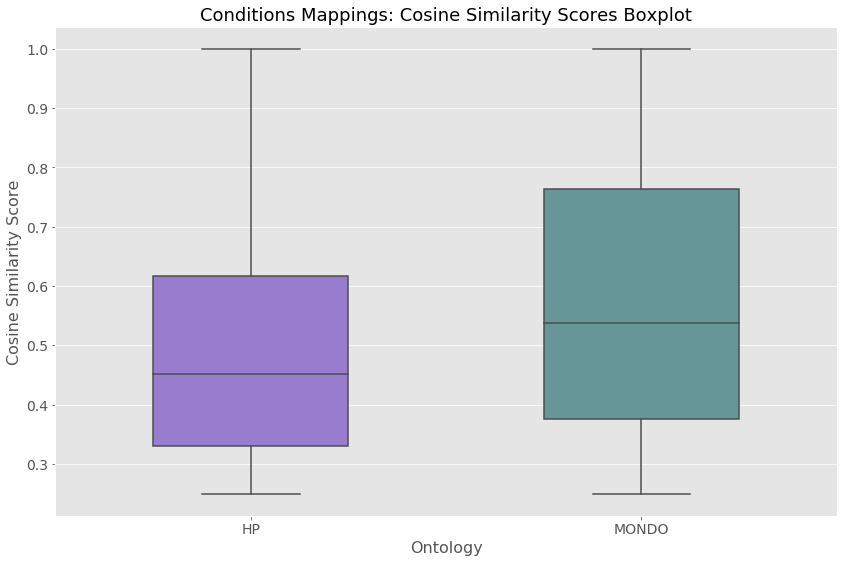

In [80]:
# create plot data
cond_sim_plot = pd.DataFrame({'Ontology':['HP'] * len(cond_hp_similarity_scores) + ['MONDO'] * len(cond_mondo_similarity_scores),
                              'Similarity_Score':cond_hp_similarity_scores + cond_mondo_similarity_scores})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='Similarity_Score', x='Ontology', data=cond_sim_plot, width=0.5, palette=my_pal)
    
plt.title('Conditions Mappings: Cosine Similarity Scores Boxplot', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Cosine Similarity Score', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()


<br>

#### Final Mapping Set    <a class="anchor" id="cond-fullmapres"></a>   
- [Human Phenotype Ontology](#full-hpo)  
- [Mondo Disease Ontology](#full-mondo)  


*Concept Frequency*

Concept frequency is only calculated for concepts that are used in practice (`n=29,129`). As shown below, there are two ways that concept frequency has been calculated: (1) raw concept counts from the `OMOP` condition occurrence table and (2) converting counts from the `OMOP` condition occurrence table that occur fewer than 100 times to 100. The median raw count is `25` (`min=1`, `max=544,618`).


In [81]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Conditions']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,760841,Conditions,1,100
1,4122179,Conditions,1,100
2,4254374,Conditions,1,100
3,4341363,Conditions,1,100
4,436140,Conditions,1,100


In [82]:
min_score = min(chco_concept_counts['CONCEPT_COUNT'])
max_score = max(chco_concept_counts['CONCEPT_COUNT'])
median_score = statistics.median(chco_concept_counts['CONCEPT_COUNT'])

print('The median concept count is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median concept count is 25 (min: 1, max: 544618)


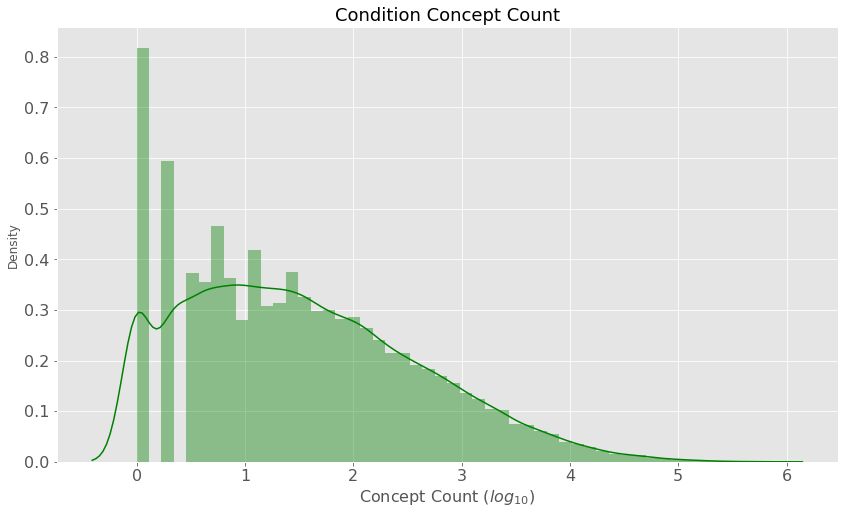

In [83]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
distplot = sns.distplot([math.log10(x) for x in list(chco_concept_counts['CONCEPT_COUNT'])], color='green')
    
plt.title('Condition Concept Count', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()


*Mapping Results*

In [84]:
# load mapping results
cond_mappings = pd.read_excel(conds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
cond_mappings.fillna('', inplace=True)

# drop unneeded columns
cond_mappings = cond_mappings[['CONCEPT_ID', 'CONCEPT_TYPE', 'STANDARD', 'CUI', 'SEMANTIC_TYPE',
                               'HP_URI', 'HP_LABEL', 'HP_MAPPING', 'HP_EVIDENCE',
                               'MONDO_URI', 'MONDO_LABEL', 'MONDO_MAPPING', 'MONDO_EVIDENCE']]

# merge concept counts
cond_mappings = cond_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# view data
cond_mappings.head(n=5)


,CONCEPT_ID,CONCEPT_TYPE,STANDARD,CUI,SEMANTIC_TYPE,HP_URI,HP_LABEL,HP_MAPPING,HP_EVIDENCE,MONDO_URI,MONDO_LABEL,MONDO_MAPPING,MONDO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,22274,Concept used in Practice,S,C0496912,Neoplastic Process,HP_0100605,neoplasm of the larynx,Automatic Exact - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C002...,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,Automatic Constructor - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_12...,Conditions,7.0,100.0
1,22281,Concept used in Practice,S,C0002895,Disease or Syndrome,HP_0001903 | HP_0002664 | HP_0010566 | HP_0001...,anemia | neoplasm | hamartoma | abnormality of...,Automatic Constructor - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C000...,MONDO_0011382,sickle cell anemia,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:meddra_10...,Conditions,3917.0,3917.0
2,22288,Concept used in Practice,S,C0013902,Disease or Syndrome,HP_0004445,elliptocytosis,Automatic Exact - Concept,OBO_DbXref-OMOP_CONCEPT_SOURCE_CODE:umls_C0013...,MONDO_0008165 | MONDO_0017319,southeast asian ovalocytosis | hereditary elli...,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_19...,Conditions,83.0,100.0
3,22340,Concept used in Practice,S,C0267092,Disease or Syndrome,HP_0002040 | HP_0001892,esophageal varix | abnormal bleeding,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_28...,MONDO_0021644,esophageal varices without bleeding,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_14...,Conditions,517.0,517.0
4,22350,Concept used in Practice,S,C0023052,Pathologic Function,HP_0012027,laryngeal edema,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C002...,MONDO_0004382,laryngeal disease,Automatic Exact - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_60...,Conditions,1244.0,1244.0


In [85]:
# split results by ontology
cond_mappings_stacked = reconfigures_dataframe(condition_onts, cond_mappings)

# split stacked data by concept type
cond_mappings_ont_data = cond_mappings_stacked.groupby('CATEGORY')


*UMLS Sematic Type*

In [86]:
# cui counts
hp_cond_map_cui_coverage = len([x for x in list(cond_mappings_stacked['CUI']) if x != 'NO CONCEPT-LEVEL CUI'])
hp_cond_map_cui_total = [x.strip() for y in list(cond_mappings_stacked['CUI']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI']
hp_cond_map_cui_unq = set(hp_cond_map_cui_total)

# umls semantic type
hp_cond_map_semantic_type = set([x.strip() for y in list(cond_mappings_stacked['SEMANTIC_TYPE']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI'])


In [87]:
cui1 = 'UMLS CUIs were found for {} clinical concepts ({} total CUIs; {} unique CUIs)'.format(hp_cond_map_cui_coverage,
                                                                                             len(hp_cond_map_cui_total),
                                                                                             len(hp_cond_map_cui_unq))
cui2 = '\nThe mapped CUIs represented {} unique Semantic Types'.format(len(hp_cond_map_semantic_type))

print(cui1, cui2)


UMLS CUIs were found for 182148 clinical concepts (186144 total CUIs; 90159 unique CUIs) 
The mapped CUIs represented 57 unique Semantic Types



<br>

***Human Phenotype Ontology Results***  <a class="anchor" id="full-hpo"></a>  

Summarizing the results shown below, there were a total of `24,409` `Concepts Used in Practice` and `50,980` `Standard SNOMED-CT Concepts` that mapped to at least 1 `HP` concept (not including `Unmapped` concepts). UMLS CUIs were found for `182,148` clinical concepts (`186,144` total CUIs, `90,159` unique CUIs) representing `57` unique Semantic Types.

**Concepts Used in Clinical Practice**  
- *Mapping Categories*  
  - Automatic Exact (1:1): `3,600` concept-level, `3,091` ancestor-level  
  - Automatic Constructor (1:Many): `125` concept-level, `1097` ancestor-level 
  - Manual: `969` Concept Similarity, `5,114` Exact, `10,413` Constructor  
  - UnMapped: `59` None, `3,367` Injury, `23` Carrier Status, `912` Complication, `359` Finding  
  
- *Mapping Evidence*   
  - `85,630` sources of (`77,031` unique)  
  - `38,289` were from dbXRefs (6,142 unique idenitfier types)  
  - `8,018` were from synonyms (12 unique combinations), covering `4` OBO synonym types   
  - `19,259` were from labels (`11` unique combinations)  
  - `11,164` were from similarity (`0.548` median, `0.25` min, `1.0` max)


**Standard SNOMED-CT Concepts**     
- *Mapping Categories*  
  - Automatic Exact (1:1): `1,165` concept-level, `11,115` ancestor-level  
  - Automatic Constructor (1:Many): `25` concept-level, `38,675` ancestor-level 
  - UnMapped: `10,693` Not Yet Mapped, `2,239` Injury, `89` Complication, `3` Finding  
  
- *Mapping Evidence*   
  - `351,913` sources of (`344,834` unique)  
  - `286,762` were from dbXRefs (5,951 unique idenitfier types)  
  - `33,213` were from synonyms (9 unique combinations), covering `4` OBO synonym types. 
  - `65,141` were from labels (`11` unique combinations)  


In [88]:
# get hpo results
cond_hp_map = cond_mappings_ont_data.get_group('HP').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_hp_map_grp = cond_hp_map.groupby('CONCEPT_TYPE')

# split stacked data by concept type
cond_hp_map_prac = cond_hp_map_grp.get_group('Concept used in Practice').drop_duplicates()
cond_hp_map_stnd = cond_hp_map_grp.get_group('Standard Concept').drop_duplicates()


CONCEPTS USED IN PRACTICE

In [89]:
print('{} OMOP concepts Used in practice with at least 1 ontology mapping'.format(len(cond_hp_map_prac[cond_hp_map_prac['CATEGORY_MAPPING'] !='Unmapped'])))


24409 OMOP concepts Used in practice with at least 1 ontology mapping


*Mapping Categories*

In [90]:
# mapping category
hp_cond_prac_map_categories = cond_hp_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_hp_map_prac_unmapped = cond_hp_map_prac[cond_hp_map_prac['CATEGORY_MAPPING'] =='Unmapped']
cond_hp_map_prac_unmapped_types = cond_hp_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()


In [91]:
map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in hp_cond_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_hp_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=1097)
  - Automatic Constructor - Concept (n=125)
  - Automatic Exact - Ancestor (n=3091)
  - Automatic Exact - Concept (n=3600)
  - Manual (n=5114)
  - Manual Constructor (n=10413)
  - Manual Exact - Concept Similarity (n=969)
  - Unmapped (n=4720) 

Unmapped reasons:
  - CARRIER STATUS (n=23)
  - COMPLICATION (n=912)
  - FINDING (n=367)
  - INJURY (n=3367)
  - NONE (n=51)


In [102]:
cond_hp_map_prac_valid

,CONCEPT_ID,CONCEPT_TYPE,STANDARD,CUI,SEMANTIC_TYPE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED,CATEGORY_URI,CATEGORY_LABEL,CATEGORY_MAPPING,CATEGORY_EVIDENCE
0,22274,Concept used in Practice,S,C0496912,Neoplastic Process,Conditions,7,100,HP_0100605,neoplasm of the larynx,Automatic Exact - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C002...
1,22281,Concept used in Practice,S,C0002895,Disease or Syndrome,Conditions,3917,3917,HP_0001903 | HP_0002664 | HP_0010566 | HP_0001...,anemia | neoplasm | hamartoma | abnormality of...,Automatic Constructor - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C000...
2,22288,Concept used in Practice,S,C0013902,Disease or Syndrome,Conditions,83,100,HP_0004445,elliptocytosis,Automatic Exact - Concept,OBO_DbXref-OMOP_CONCEPT_SOURCE_CODE:umls_C0013...
3,22340,Concept used in Practice,S,C0267092,Disease or Syndrome,Conditions,517,517,HP_0002040 | HP_0001892,esophageal varix | abnormal bleeding,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_28...
4,22350,Concept used in Practice,S,C0023052,Pathologic Function,Conditions,1244,1244,HP_0012027,laryngeal edema,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C002...
...,...,...,...,...,...,...,...,...,...,...,...,...
92993,46274096,Concept used in Practice,S,C4039625,Disease or Syndrome,Conditions,2,100,HP_0001259 | HP_0000230,coma | gingivitis,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C001...
92996,46274123,Concept used in Practice,S,C2888178,Disease or Syndrome,Conditions,1,100,HP_0003765 | HP_0001369,psoriasiform dermatitis | arthritis,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C003...
92997,46274124,Concept used in Practice,S,C4040386,Finding,Conditions,1,100,HP_0012825 | HP_0002099,mild | asthma,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_19...
92998,46274126,Concept used in Practice,S,C4039870,Disease or Syndrome,Conditions,1,100,HP_0006480 | HP_0000670,premature loss of teeth | carious teeth,Manual Constructor,CONCEPT_SIMILARITY:HP_0000670_0.286 | Hand Map...


In [109]:
# concept frequency by mapping type 
cond_hp_map_prac_valid = cond_hp_map_prac[cond_hp_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure ocunts data is correct type
cond_hp_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(cond_hp_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
cond_hp_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
cond_hp_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                 
                                            min       max median
CATEGORY_MAPPING                                                
Automatic Constructor - Ancestor            1.0  160610.0   19.0
Automatic Constructor - Concept             1.0   72099.0  490.0
Automatic Exact - Ancestor                  1.0  471512.0   19.0
Automatic Exact - Concept                   1.0  544618.0  138.0
Manual                                      1.0  302393.0   19.0
Manual Constructor                          1.0  248363.0   19.0
Manual Exact - Concept Similarity           1.0  183729.0   24.0

*Mapping Evidence*

In [110]:
# evidence
cond_hp_map_prac_valid_evidence_total = [x.split for y in cond_hp_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ')]
cond_hp_map_prac_valid_evidence_unique = set(cond_hp_map_prac_valid_evidence_total)

# get dbxref info
cond_hp_map_prac_valid_evidence_dbxref_total = [x.split(':')[1] for y in cond_hp_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'DbXref' in x]
cond_hp_map_prac_valid_evidence_dbxref_set = set(cond_hp_map_prac_valid_evidence_dbxref_total)

# get synomym
cond_hp_map_prac_valid_evidence_synonym_total = [x.split(':')[0] for y in cond_hp_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'Synonym' in x]
cond_hp_map_prac_valid_evidence_synonym_set = set(cond_hp_map_prac_valid_evidence_synonym_total)
# synonym types
cond_hp_map_prac_valid_evidence_synonym_types = Counter([x.split('_')[1].strip('-OMOP') for x in cond_hp_map_prac_valid_evidence_synonym_total])

# labels
cond_hp_map_prac_valid_evidence_label_total = [x.split(':')[0] for y in cond_hp_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'LABEL' in x]
cond_hp_map_prac_valid_evidence_label_set = set(cond_hp_map_prac_valid_evidence_label_total)

# similarity
cond_hp_map_prac_valid_evidence_similarity = [float(x.split('_')[-1]) for y in cond_hp_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'SIMILARITY' in x]
min_score = min(cond_hp_map_prac_valid_evidence_similarity)
max_score = max(cond_hp_map_prac_valid_evidence_similarity)
median_score = statistics.median(cond_hp_map_prac_valid_evidence_similarity)


In [111]:
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_hp_map_prac_valid_evidence_total),
                                                                        len(cond_hp_map_prac_valid_evidence_unique))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_hp_map_prac_valid_evidence_dbxref_total),
                                                                      len(cond_hp_map_prac_valid_evidence_dbxref_set))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_hp_map_prac_valid_evidence_synonym_total),
                                                                                                      len(cond_hp_map_prac_valid_evidence_synonym_set),
                                                                                                      len(cond_hp_map_prac_valid_evidence_synonym_types))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_hp_map_prac_valid_evidence_label_total),
                                                                     len(cond_hp_map_prac_valid_evidence_label_set))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(cond_hp_map_prac_valid_evidence_similarity),
                                                                                         median_score, min_score, max_score)

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 85630 (77031 unique) pieces of evidence 
Among the evidence, 38289 were from dbXRefs (6142 unique) 
Among the evidence, 8018 were from synonyms (12 unique), covering 4 OBO synonym types 
Among the evidence, 19259 were from labels (11 unique) 
Among the evidence, 11164 were from similarity (0.548 median, 0.25 min, 1.0 max)


STANDARD SNOMED-CT CONCEPTS

In [112]:
print('{} OMOP standard concepts with at least 1 ontology mapping'.format(len(cond_hp_map_stnd[cond_hp_map_stnd['CATEGORY_MAPPING'] !='Unmapped'])))


50980 OMOP standard concepts with at least 1 ontology mapping


*Mapping Categories*

In [113]:
# mapping category
hp_cond_stnd_map_categories = cond_hp_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_hp_map_stnd_unmapped = cond_hp_map_stnd[cond_hp_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
cond_hp_map_stnd_unmapped_types = cond_hp_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()


In [114]:
map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in hp_cond_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_hp_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=38675)
  - Automatic Constructor - Concept (n=25)
  - Automatic Exact - Ancestor (n=11115)
  - Automatic Exact - Concept (n=1165)
  - Unmapped (n=13023) 

Unmapped reasons:
  - COMPLICATION (n=89)
  - FINDING (n=3)
  - INJURY (n=2239)
  - NOT YET MAPPED (n=10692)


*Mapping Evidence*

In [154]:
# concept frequency by mapping type 
cond_hp_map_stnd_valid = cond_hp_map_stnd[cond_hp_map_stnd['CATEGORY_MAPPING'] !='Unmapped']

# evidence
cond_hp_map_stnd_valid_evidence_total = [x.split for y in cond_hp_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ')]
cond_hp_map_stnd_valid_evidence_unique = set(cond_hp_map_stnd_valid_evidence_total)

# get dbxref info
cond_hp_map_stnd_valid_evidence_dbxref_total = [x.split(':')[1] for y in cond_hp_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'DbXref' in x]
cond_hp_map_stnd_valid_evidence_dbxref_set = set(cond_hp_map_stnd_valid_evidence_dbxref_total)

# get synomym
cond_hp_map_stnd_valid_evidence_synonym_total = [x.split(':')[0] for y in cond_hp_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'Synonym' in x]
cond_hp_map_stnd_valid_evidence_synonym_set = set(cond_hp_map_stnd_valid_evidence_synonym_total)
# synonym types
cond_hp_map_stnd_valid_evidence_synonym_types = Counter([x.split('_')[1].strip('-OMOP') for x in cond_hp_map_stnd_valid_evidence_synonym_total])

# labels
cond_hp_map_stnd_valid_evidence_label_total = [x.split(':')[0] for y in cond_hp_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'LABEL' in x]
cond_hp_map_stnd_valid_evidence_label_set = set(cond_hp_map_stnd_valid_evidence_label_total)


In [155]:
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_hp_map_stnd_valid_evidence_total),
                                                                        len(cond_hp_map_stnd_valid_evidence_unique))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_hp_map_stnd_valid_evidence_dbxref_total),
                                                                      len(cond_hp_map_stnd_valid_evidence_dbxref_set))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_hp_map_stnd_valid_evidence_synonym_total),
                                                                                                      len(cond_hp_map_stnd_valid_evidence_synonym_set),
                                                                                                      len(cond_hp_map_stnd_valid_evidence_synonym_types))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_hp_map_stnd_valid_evidence_label_total),
                                                                     len(cond_hp_map_stnd_valid_evidence_label_set))

print(ev1, ev2, ev3, ev4)


The valid mappings had 351913 (344834 unique) pieces of evidence 
Among the evidence, 286762 were from dbXRefs (5951 unique) 
Among the evidence, 33213 were from synonyms (9 unique), covering 4 OBO synonym types 
Among the evidence, 65141 were from labels (11 unique)


<br>

***Mondo Disease Ontology Results***  <a class="anchor" id="full-mondo"></a>  

Summarizing the results shown below, there were a total of `20,008` `Concepts Used in Practice` and `51,696` `Standard SNOMED-CT Concepts` that mapped to at least 1 `MONDO` concept (not including `Unmapped` concepts). UMLS CUIs were found for `182,148` clinical concepts (`186,144` total CUIs, `90,159` unique CUIs) representing `57` unique Semantic Types. 

**Concepts Used in Clinical Practice**  
- *Mapping Categories*  
  - Automatic Exact (1:1): `4,834` concept-level, `5,698` ancestor-level  
  - Automatic Constructor (1:Many): `651` concept-level, `4,437` ancestor-level 
  - Manual: `1,018` Concept Similarity, `553` Exact, `2,817` Constructor  
  - UnMapped: `84` None, `3,367` Injury, `4` Carrier Status, `912` Complication, `4,754` Finding  
  
- *Mapping Evidence*   
  - `151,194` sources of (`149,966` unique)  
  - `51,862` were from dbXRefs (5,341 unique idenitfier types)  
  - `64,260` were from synonyms (12 unique combinations), covering `4` OBO synonym types   
  - `75,650` were from labels (`11` unique combinations)  
  - `12,789` were from similarity (`0.76` median, `0.25` min, `1.0` max)


**Standard SNOMED-CT Concepts**    
- *Mapping Categories*  
  - Automatic Exact (1:1): `4,283` concept-level, `4,885` ancestor-level  
  - Automatic Constructor (1:Many): `254` concept-level, `42,274` ancestor-level 
  - UnMapped: `495` Not Yet Mapped, `2,239` Injury, `89` Complication, `9,484` Finding  
  
- *Mapping Evidence*   
  - `513,051` sources of (`500,040` unique)  
  - `368,655` were from dbXRefs (7,203 unique idenitfier types)  
  - `95,432` were from synonyms (11 unique combinations), covering `4` OBO synonym types. 
  - `131,928` were from labels (`11` unique combinations) 


In [117]:
# get mondo results
cond_mondo_map = cond_mappings_ont_data.get_group('MONDO').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_mondo_map_grp = cond_mondo_map.groupby('CONCEPT_TYPE')

# split stacked data by concept type
cond_mondo_map_prac = cond_mondo_map_grp.get_group('Concept used in Practice').drop_duplicates()
cond_mondo_map_stnd = cond_mondo_map_grp.get_group('Standard Concept').drop_duplicates()


CONCEPTS USED IN PRACTICE

In [118]:
print('{} OMOP concepts Used in practice with at least 1 ontology mapping'.format(len(cond_mondo_map_prac[cond_mondo_map_prac['CATEGORY_MAPPING'] !='Unmapped'])))

20008 OMOP concepts Used in practice with at least 1 ontology mapping


*UMLS Sematic Type*

In [119]:
# cui counts
mondo_cond_prac_map_cui_coverage = len([x for x in list(cond_mondo_map_prac['CUI']) if x != 'NO CONCEPT-LEVEL CUI'])
mondo_cond_prac_map_cui_total = [x.strip() for y in list(cond_mondo_map_prac['CUI']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI']
mondo_cond_prac_map_cui_unq = set(mondo_cond_prac_map_cui_total)

# umls semantic type
mondo_cond_prac_map_semantic_type = set([x.strip() for y in list(cond_mondo_map_prac['SEMANTIC_TYPE']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI'])


In [120]:
cui1 = 'UMLS CUIs were found for {} clinical concepts ({} total CUIs; {} unique CUIs)'.format(mondo_cond_prac_map_cui_coverage,
                                                                                             len(mondo_cond_prac_map_cui_total),
                                                                                             len(mondo_cond_prac_map_cui_unq))
cui2 = '\nThe mapped CUIs represented {} unique Semantic Types'.format(len(mondo_cond_prac_map_semantic_type))

print(cui1, cui2)


UMLS CUIs were found for 29120 clinical concepts (30530 total CUIs; 29277 unique CUIs) 
The mapped CUIs represented 48 unique Semantic Types


*Mapping Categories*

In [121]:
# mapping category
mondo_cond_prac_map_categories = cond_mondo_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_mondo_map_prac_unmapped = cond_mondo_map_prac[cond_mondo_map_prac['CATEGORY_MAPPING'] =='Unmapped']
cond_mondo_map_prac_unmapped_types = cond_mondo_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()


In [122]:
map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in mondo_cond_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_mondo_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=4437)
  - Automatic Constructor - Concept (n=651)
  - Automatic Exact - Ancestor (n=5698)
  - Automatic Exact - Concept (n=4834)
  - Manual (n=1018)
  - Manual Constructor (n=2817)
  - Manual Exact - Concept Similarity (n=553)
  - Unmapped (n=9121) 

Unmapped reasons:
  - CARRIER STATUS (n=4)
  - COMPLICATION (n=912)
  - FINDING (n=4754)
  - INJURY (n=3367)
  - NONE (n=84)


In [124]:
# concept frequency by mapping type 
cond_mondo_map_prac_valid = cond_mondo_map_prac[cond_mondo_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure ocunts data is correct type
cond_mondo_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(cond_mondo_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
cond_mondo_map_prac_valid['CONCEPT_COUNT'].describe()

# cond_mondo_map_prac_valid['CONCEPT_COUNT'].median()

# print concept frequency by mapping category
cond_mondo_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                 
                                            min       max median
CATEGORY_MAPPING                                                
Automatic Constructor - Ancestor            1.0   91994.0   16.0
Automatic Constructor - Concept             1.0  255219.0  115.0
Automatic Exact - Ancestor                  1.0  144587.0   20.0
Automatic Exact - Concept                   1.0  471512.0   61.0
Manual                                      1.0  134677.0   18.0
Manual Constructor                          1.0  302393.0   19.0
Manual Exact - Concept Similarity           1.0  160610.0   20.0

*Mapping Evidence*

In [125]:
# evidence
cond_mondo_map_prac_valid_evidence_total = [x.split for y in cond_mondo_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ')]
cond_mondo_map_prac_valid_evidence_unique = set(cond_mondo_map_prac_valid_evidence_total)

# get dbxref info
cond_mondo_map_prac_valid_evidence_dbxref_total = [x.split(':')[1] for y in cond_mondo_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'DbXref' in x]
cond_mondo_map_prac_valid_evidence_dbxref_set = set(cond_mondo_map_prac_valid_evidence_dbxref_total)

# get synomym
cond_mondo_map_prac_valid_evidence_synonym_total = [x.split(':')[0] for y in cond_mondo_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'Synonym' in x]
cond_mondo_map_prac_valid_evidence_synonym_set = set(cond_mondo_map_prac_valid_evidence_synonym_total)
# synonym types
cond_mondo_map_prac_valid_evidence_synonym_types = Counter([x.split('_')[1].strip('-OMOP') for x in cond_mondo_map_prac_valid_evidence_synonym_total])

# labels
cond_mondo_map_prac_valid_evidence_label_total = [x.split(':')[0] for y in cond_mondo_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'LABEL' in x]
cond_mondo_map_prac_valid_evidence_label_set = set(cond_mondo_map_prac_valid_evidence_label_total)

# similarity
cond_mondo_map_prac_valid_evidence_similarity = [float(x.split('_')[-1]) for y in cond_mondo_map_prac_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'SIMILARITY' in x]
min_score = min(cond_mondo_map_prac_valid_evidence_similarity)
max_score = max(cond_mondo_map_prac_valid_evidence_similarity)
median_score = statistics.median(cond_mondo_map_prac_valid_evidence_similarity)


In [126]:
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_mondo_map_prac_valid_evidence_total),
                                                                        len(cond_mondo_map_prac_valid_evidence_unique))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_mondo_map_prac_valid_evidence_dbxref_total),
                                                                      len(cond_mondo_map_prac_valid_evidence_dbxref_set))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_mondo_map_prac_valid_evidence_synonym_total),
                                                                                                      len(cond_mondo_map_prac_valid_evidence_synonym_set),
                                                                                                      len(cond_mondo_map_prac_valid_evidence_synonym_types))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_mondo_map_prac_valid_evidence_label_total),
                                                                     len(cond_mondo_map_prac_valid_evidence_label_set))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(cond_mondo_map_prac_valid_evidence_similarity),
                                                                                         median_score, min_score, max_score)

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 151194 (149966 unique) pieces of evidence 
Among the evidence, 51862 were from dbXRefs (5341 unique) 
Among the evidence, 64260 were from synonyms (12 unique), covering 4 OBO synonym types 
Among the evidence, 75650 were from labels (11 unique) 
Among the evidence, 12789 were from similarity (0.76 median, 0.25 min, 1.0 max)


STANDARD SNOMED-CT CONCEPTS

In [127]:
print('{} OMOP standard concepts with at least 1 ontology mapping'.format(len(cond_mondo_map_stnd[cond_mondo_map_stnd['CATEGORY_MAPPING'] !='Unmapped'])))

51696 OMOP standard concepts with at least 1 ontology mapping


*Mapping Categories*

In [128]:
# mapping category
mondo_cond_stnd_map_categories = cond_mondo_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_mondo_map_stnd_unmapped = cond_mondo_map_stnd[cond_mondo_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
cond_mondo_map_stnd_unmapped_types = cond_mondo_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()


In [129]:
map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in mondo_cond_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_mondo_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=42274)
  - Automatic Constructor - Concept (n=254)
  - Automatic Exact - Ancestor (n=4885)
  - Automatic Exact - Concept (n=4283)
  - Unmapped (n=12307) 

Unmapped reasons:
  - COMPLICATION (n=89)
  - FINDING (n=9484)
  - INJURY (n=2239)
  - NOT YET MAPPED (n=495)


*Mapping Evidence*

In [156]:
# concept frequency by mapping type 
cond_mondo_map_stnd_valid = cond_mondo_map_stnd[cond_mondo_map_stnd['CATEGORY_MAPPING'] !='Unmapped']

# evidence
cond_mondo_map_stnd_valid_evidence_total = [x.split for y in cond_mondo_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ')]
cond_mondo_map_stnd_valid_evidence_unique = set(cond_mondo_map_stnd_valid_evidence_total)

# get dbxref info
cond_mondo_map_stnd_valid_evidence_dbxref_total = [x.split(':')[1] for y in cond_mondo_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'DbXref' in x]
cond_mondo_map_stnd_valid_evidence_dbxref_set = set(cond_mondo_map_stnd_valid_evidence_dbxref_total)

# get synomym
cond_mondo_map_stnd_valid_evidence_synonym_total = [x.split(':')[0] for y in cond_mondo_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'Synonym' in x]
cond_mondo_map_stnd_valid_evidence_synonym_set = set(cond_mondo_map_stnd_valid_evidence_synonym_total)
# synonym types
cond_mondo_map_stnd_valid_evidence_synonym_types = Counter([x.split('_')[1].strip('-OMOP') for x in cond_mondo_map_stnd_valid_evidence_synonym_total])

# labels
cond_mondo_map_stnd_valid_evidence_label_total = [x.split(':')[0] for y in cond_mondo_map_stnd_valid['CATEGORY_EVIDENCE'] for x in y.split(' | ') if 'LABEL' in x]
cond_mondo_map_stnd_valid_evidence_label_set = set(cond_mondo_map_stnd_valid_evidence_label_total)


In [157]:
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_mondo_map_stnd_evidence_total),
                                                                        len(cond_mondo_map_stnd_evidence_unique))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_mondo_map_stnd_evidence_dbxref_total),
                                                                      len(cond_mondo_map_stnd_evidence_dbxref_set))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_mondo_map_stnd_evidence_synonym_total),
                                                                                                      len(cond_mondo_map_stnd_evidence_synonym_set),
                                                                                                      len(cond_mondo_map_stnd_evidence_synonym_types))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_mondo_map_stnd_evidence_label_total),
                                                                     len(cond_mondo_map_stnd_evidence_label_set))

print(ev1, ev2, ev3, ev4)


The valid mappings had 513051 (500040 unique) pieces of evidence 
Among the evidence, 368655 were from dbXRefs (7203 unique) 
Among the evidence, 95432 were from synonyms (11 unique), covering 4 OBO synonym types 
Among the evidence, 131928 were from labels (11 unique)


***

**Click [here](#cond-mapping-results) to return to the Condition Occurrence Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

### Drug Ingredients <a class="anchor" id="mapping-drugs"></a>

***

**SQL Queries**  
- [x] Drug Exposure Ingredients Used in Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_drugexposure-sql))  
- [x] Standard RxNorm Drug Ingredients Concepts ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_drugexposure_allstandardconcepts-sql))  

**Data Description:**  
A total of `204,598` drug-ingredient concepts were eligble for mapping. The first waved returned all drug concepts ids used at least 1 time in practice (`9,175` drugs; `1,697` ingredients). The second wave returned all standard drug concepts ids from RxNorm (`148,239` drugs; `11,808` ingredients). Once the concepts used in practice were removed, there were `139,064` standard RxNorm ingredient concepts and `10,111` standard RxNorm ingredient concepts. Of these, `119,478` drug concept ids and `4,248` ingredient ids were able to be automatically mapped to at least 1 ontology concept using an automatic alignment approach (i.e. DbXRef and exact string alignment to concept strings and synonyms). 

For each wave, the datasets included data for drugs and ingredients at both the concept and ancestor level. Details included below:  

**Concepts used in Practice:**  
- *Concept-Level*
  - *Drugs*  
    - `9,175` source codes, `9,175` labels, and `19,498` synonyms  
    - Concept-level data came from the following vocabularies: `RxNorm` 
  - *Ingredients*  
    - `1,697` source codes, `1,697` labels, and `1,869` synonyms  
    - Concept-level data came from the following vocabularies: `SPL`, `RxNorm` 
- *Ancestor-Level*
  - *Drugs*  
    - `984,567` source codes and `796,996` labels  
    - Ancestor-level data came from the following vocabularies: `CVX`, `VA Class`, `NDFRT`, `ATC`, `SPL`, `RxNorm`, `Cohort`   
  - *Ingredients*  
    - `36,117` source codes and `36,116` labels  
    - Ancestor-level data came from the following vocabularies: `SPL`, `RxNorm` 

**Standard RxNorm Concepts:**  
- *Concept-Level*
  - *Drugs*  
    - `139,064` source codes, `139,064` labels, and `187,099` synonyms  
    - Concept-level data came from the following vocabularies: `RxNorm` 
  - *Ingredients*  
    - `10,111` source codes, `10,111` labels, and `11,236` synonyms  
    - Concept-level data came from the following vocabularies: `SPL`, `RxNorm` 
- *Ancestor-Level*
  - *Drugs*  
    - `9,543,589` source codes and `8,793,409` labels  
    - Ancestor-level data came from the following vocabularies: `CVX`, `VA Class`, `NDFRT`, `ATC`, `SPL`, `RxNorm`, `Cohort`  
  - *Ingredients*  
    - `19,811` source codes and `19,811` labels  
    - Ancestor-level data came from the following vocabularies: `SPL`, `RxNorm`  


**Ontology Data:**  
`OMOP` Drug Exposure ingredient concept ids were mapped to:  
- Chemicals, hormones, and enzymes ([Chemical Entities of Biological Interest (CHEBI)](https://www.ebi.ac.uk/chebi/)) 
- Organisms ([NCBI Organism Taxonomy (NCBITaxon)](https://www.ncbi.nlm.nih.gov/taxonomy))  
- Proteins ([Protein Ontology (PR)](https://proconsortium.org/))  
- Vaccines/Immunizations ([Vaccine Ontology (VO)](http://www.violinet.org/vaccineontology/))  


**CLINICAL MAPPING DATA**

In [132]:
# load link to drug mapping data 
drug_data = pd.read_csv(medications, sep=',', header=0)
drug_data.fillna('', inplace=True)

# view data
drug_data.head()


,CONCEPT_ID,CONCEPT_SOURCE_CODE,CONCEPT_LABEL,CONCEPT_VOCAB,CONCEPT_VOCAB_VERSION,CONCEPT_SYNONYM,ANCESTOR_CONCEPT_ID,ANCESTOR_SOURCE_CODE,ANCESTOR_LABEL,ANCESTOR_VOCAB,...,INGREDIENT_SYNONYM,INGRED_ANCESTOR_CONCEPT_ID,INGRED_ANCESTOR_SOURCE_CODE,INGRED_ANCESTOR_LABEL,INGRED_ANCESTOR_VOCAB,INGRED_ANCESTOR_VOCAB_VERSION,CONCEPT_TYPE,ANCESTOR_TYPE,INGREDIENT_TYPE,INGRED_ANCESTOR_TYPE
0,40062881,rxnorm:93278,Mesna Injectable Solution [Mesnex],RxNorm,RxNorm Full 20180507,Mesna Injectable Solution [Mesnex],4350600 | 4345980 | 4349997 | 36217210 | 36225...,ndfrt:N0000008257 | ndfrt:N0000009556 | ndfrt:...,"Hydrocarbons | MESNEX - mesna injection, solut...",SPL | NDFRT | RxNorm,...,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507,Standard Concept,Standard Concept,Concept Used in Practice,Concept Used in Practice
1,40173225,rxnorm:899349,Mesna 100 MG/ML [Mesnex],RxNorm,RxNorm Full 20180507,Mesna 100 MG/ML [Mesnex],4341296 | 4267037 | 4352026 | 1354739 | 433090...,ndfrt:N0000001224 | spl:f83fb36f-d7ce-4d0f-9f1...,Hemorrhage | Sulfonic Acids | Cystitis | mesna...,SPL | NDFRT | RxNorm,...,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507,Standard Concept,Standard Concept,Concept Used in Practice,Concept Used in Practice
2,1354699,rxnorm:142113,Mesna 400 MG Oral Tablet,RxNorm,RxNorm Full 20180507,Mesna 400 MG Oral Tablet,4265103 | 4264935 | 44786237 | 21605269 | 4350...,ndfrt:N0000000894 | ndfrt:N0000008227 | ndfrt:...,"Pathological Conditions, Signs and Symptoms | ...",RxNorm | NDFRT | ATC | VA Class | SPL,...,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507,Concept Used in Practice,Standard Concept,Concept Used in Practice,Concept Used in Practice
3,19085964,rxnorm:330706,Mesna 16.67 MG/ML,RxNorm,RxNorm Full 20180507,Mesna 16.67 MG/ML,4340569 | 4341728 | 1354698 | 4331211 | 435036...,ndfrt:N0000008257 | ndfrt:N0000003085 | ndfrt:...,Renal/Urological Activity Alteration | Organic...,NDFRT | RxNorm,...,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507,Standard Concept,Standard Concept,Concept Used in Practice,Concept Used in Practice
4,19090545,rxnorm:334033,Mesna 400 MG,RxNorm,RxNorm Full 20180507,Mesna 400 MG,4350600 | 4350438 | 4324301 | 4327511 | 447862...,ndfrt:N0000189389 | ndfrt:N0000189388 | rxnorm...,VARIOUS | Chemically-Induced Disorders | Cysti...,SPL | NDFRT | ATC | VA Class | RxNorm,...,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507,Standard Concept,Standard Concept,Concept Used in Practice,Concept Used in Practice


In [133]:
# split results by drug and ingredient
drug_grp = drug_data.groupby('CONCEPT_TYPE')
ingredient_grp = drug_data.groupby('INGREDIENT_TYPE')

# identify relevant columns 
drug_cols = [x for x in drug_data.columns if x.startswith('CONCEPT')][:-1]
drug_anc_cols = [x for x in drug_data.columns if x.startswith('ANCESTOR')][:-1]
ingredient_cols = [x for x in drug_data.columns if x.startswith('INGREDIENT')][:-1]
ingredient_anc_cols = [x for x in drug_data.columns if x.startswith('INGRED_ANCESTOR')][:-1]


In [134]:
# print results
all1 = 'There were {} drug-ingredients concepts eligible for mapping'.format(len(drug_data))
all2 = '\n  - Drug concepts (unique): {}'.format(len(set(drug_data['CONCEPT_ID'])))
all3 = '\n  - Ingredients concepts (unique): {}'.format(len(set(drug_data['INGREDIENT_CONCEPT_ID'])))

print(all1, all2, all3)

There were 204598 drug-ingredients concepts eligible for mapping 
  - Drug concepts (unique): 148239 
  - Ingredients concepts (unique): 11808


*Concepts Used In Practice*

In [135]:
# drugs
drug_prac = drug_grp.get_group('Concept Used in Practice').drop_duplicates()
drug_prac_concept = drug_prac[drug_cols].dropna(how='all').drop_duplicates()
drug_prac_ancestor = drug_prac[drug_anc_cols].dropna(how='all').drop_duplicates()

# ingredients
ingredient_prac = ingredient_grp.get_group('Concept Used in Practice').drop_duplicates()
ingredient_prac_concept = ingredient_prac[ingredient_cols].dropna(how='all').drop_duplicates()
ingredient_prac_ancestor = ingredient_prac[ingredient_anc_cols].dropna(how='all').drop_duplicates()

# concept-level
prac_con_src_code = [x for y in drug_prac_concept['CONCEPT_SOURCE_CODE'] for x in y.split(' | ')]
prac_con_lab_code = [x for y in drug_prac_concept['CONCEPT_LABEL'] for x in y.split(' | ')]
prac_con_syn_code = [x for y in drug_prac_concept['CONCEPT_SYNONYM'] for x in y.split(' | ')]
prac_con_vocab_code = ', '.join(set([x for y in drug_prac_concept['CONCEPT_VOCAB'] for x in y.split(' | ')]))
prac_anc_ids = [x for y in drug_prac_ancestor['ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
prac_anc_src_code = [x for y in drug_prac_ancestor['ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
prac_anc_lab_code = [x for y in drug_prac_ancestor['ANCESTOR_LABEL'] for x in y.split(' | ')]
prac_anc_vocab_code = ', '.join(set([x for y in drug_prac_ancestor['ANCESTOR_VOCAB'] for x in y.split(' | ')]))

# ingredient-level
prac_igd_src_code = [x for y in ingredient_prac_concept['INGREDIENT_SOURCE_CODE'] for x in y.split(' | ')]
prac_igd_lab_code = [x for y in ingredient_prac_concept['INGREDIENT_LABEL'] for x in y.split(' | ')]
prac_igd_syn_code = [x for y in ingredient_prac_concept['INGREDIENT_SYNONYM'] for x in y.split(' | ')]
prac_igd_vocab_code = ', '.join(set([x for y in ingredient_prac_concept['INGREDIENT_VOCAB'] for x in y.split(' | ')]))
prac_anc_igd_ids = [x for y in ingredient_prac_ancestor['INGRED_ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
prac_anc_igd_src_code = [x for y in ingredient_prac_ancestor['INGRED_ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
prac_anc_igd_lab_code = [x for y in ingredient_prac_ancestor['INGRED_ANCESTOR_LABEL'] for x in y.split(' | ')]
prac_anc_igd_vocab_code = ', '.join(set([x for y in ingredient_prac_ancestor['INGRED_ANCESTOR_VOCAB'] for x in y.split(' | ')]))


In [136]:
# concepts used in practice data
res1 = '\nAt the drug concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(prac_con_src_code),
                                                                                                    len(prac_con_lab_code),
                                                                                                    len(prac_con_syn_code))
res2 = '\nDrug concept-level data came from the following vocabularies: {}'.format(prac_con_vocab_code)
res3 = '\nAt the ingredient concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(prac_igd_src_code),
                                                                                           len(prac_igd_lab_code),
                                                                                           len(prac_igd_syn_code))
res4 = '\nIngredient concept-level data came from the following vocabularies: {}'.format(prac_igd_vocab_code)
res5 = '\n\nAt the drug ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(prac_anc_ids),
                                                                                                    len(prac_anc_src_code),
                                                                                                    len(prac_anc_lab_code))
res6 = '\nDrug ancestor-level data came from the following vocabularies: {}'.format(prac_anc_vocab_code)
res7 = '\nAt the ingredient ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(prac_anc_igd_ids),
                                                                                                    len(prac_anc_igd_src_code),
                                                                                                    len(prac_anc_igd_lab_code))
res8 = '\nIngredient ancestor-level data came from the following vocabularies: {}'.format(prac_anc_igd_vocab_code)

print(res1, res2, res3, res4, res5, res6, res7, res8)


At the drug concept-level, there were 9175 source codes, 9175 labels, and 19498 synonyms 
Drug concept-level data came from the following vocabularies: RxNorm 
At the ingredient concept-level, there were 1697 source codes, 1697 labels, and 1869 synonyms 
Ingredient concept-level data came from the following vocabularies: SPL, RxNorm 

At the drug ancestor-level, there were 984567 concept ids, 984567 source codes and 796996 labels 
Drug ancestor-level data came from the following vocabularies: VA Class, CVX, SPL, ATC, NDFRT, Cohort, RxNorm 
At the ingredient ancestor-level, there were 36117 concept ids, 36117 source codes and 36116 labels 
Ingredient ancestor-level data came from the following vocabularies: SPL, RxNorm


*Standard RxNorm Concepts*

In [137]:
# drugs
drug_stnd = drug_grp.get_group('Standard Concept').drop_duplicates()
drug_stnd_concept = drug_stnd[drug_cols].dropna(how='all').drop_duplicates()
drug_stnd_ancestor = drug_stnd[drug_anc_cols].dropna(how='all').drop_duplicates()

# ingredients
ingredient_stnd = ingredient_grp.get_group('Standard Concept').drop_duplicates()
ingredient_stnd_concept = ingredient_stnd[ingredient_cols].dropna(how='all').drop_duplicates()
ingredient_stnd_ancestor = ingredient_stnd[ingredient_anc_cols].dropna(how='all').drop_duplicates()

# concept-level
stnd_con_src_code = [x for y in drug_stnd_concept['CONCEPT_SOURCE_CODE'] for x in y.split(' | ')]
stnd_con_lab_code = [x for y in drug_stnd_concept['CONCEPT_LABEL'] for x in y.split(' | ')]
stnd_con_syn_code = [x for y in drug_stnd_concept['CONCEPT_SYNONYM'] for x in y.split(' | ')]
stnd_con_vocab_code = ', '.join(set([x for y in drug_stnd_concept['CONCEPT_VOCAB'] for x in y.split(' | ')]))
stnd_anc_ids = [x for y in drug_stnd_ancestor['ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
stnd_anc_src_code = [x for y in drug_stnd_ancestor['ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
stnd_anc_lab_code = [x for y in drug_stnd_ancestor['ANCESTOR_LABEL'] for x in y.split(' | ')]
stnd_anc_vocab_code = ', '.join(set([x for y in drug_stnd_ancestor['ANCESTOR_VOCAB'] for x in y.split(' | ')]))

# ingredient-level
stnd_igd_src_code = [x for y in ingredient_stnd_concept['INGREDIENT_SOURCE_CODE'] for x in y.split(' | ')]
stnd_igd_lab_code = [x for y in ingredient_stnd_concept['INGREDIENT_LABEL'] for x in y.split(' | ')]
stnd_igd_syn_code = [x for y in ingredient_stnd_concept['INGREDIENT_SYNONYM'] for x in y.split(' | ')]
stnd_igd_vocab_code = ', '.join(set([x for y in ingredient_stnd_concept['INGREDIENT_VOCAB'] for x in y.split(' | ')]))
stnd_anc_igd_ids = [x for y in ingredient_stnd_ancestor['INGRED_ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
stnd_anc_igd_src_code = [x for y in ingredient_stnd_ancestor['INGRED_ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
stnd_anc_igd_lab_code = [x for y in ingredient_stnd_ancestor['INGRED_ANCESTOR_LABEL'] for x in y.split(' | ')]
stnd_anc_igd_vocab_code = ', '.join(set([x for y in ingredient_stnd_ancestor['INGRED_ANCESTOR_VOCAB'] for x in y.split(' | ')]))


In [138]:
# standard RxNorm concepts
res1 = '\nAt the drug concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(stnd_con_src_code),
                                                                                                    len(stnd_con_lab_code),
                                                                                                    len(stnd_con_syn_code))
res2 = '\nDrug concept-level data came from the following vocabularies: {}'.format(stnd_con_vocab_code)
res3 = '\nAt the ingredient concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(stnd_igd_src_code),
                                                                                                          len(stnd_igd_lab_code),
                                                                                                          len(stnd_igd_syn_code))
res4 = '\nIngredient concept-level data came from the following vocabularies: {}'.format(stnd_igd_vocab_code)
res5 = '\n\nAt the drug ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(stnd_anc_ids),
                                                                                                         len(stnd_anc_src_code),
                                                                                                         len(stnd_anc_lab_code))
res6 = '\nDrug ancestor-level data came from the following vocabularies: {}'.format(stnd_anc_vocab_code)
res7 = '\nAt the ingredient ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(stnd_anc_igd_ids),
                                                                                                             len(stnd_anc_igd_src_code),
                                                                                                             len(stnd_anc_igd_lab_code))
res8 = '\nIngredient ancestor-level data came from the following vocabularies: {}'.format(stnd_anc_igd_vocab_code)

print(res1, res2, res3, res4, res5, res6, res7, res8)


At the drug concept-level, there were 139064 source codes, 139064 labels, and 187099 synonyms 
Drug concept-level data came from the following vocabularies: RxNorm 
At the ingredient concept-level, there were 10111 source codes, 10111 labels, and 11236 synonyms 
Ingredient concept-level data came from the following vocabularies: SPL, RxNorm 

At the drug ancestor-level, there were 9543589 concept ids, 9543589 source codes and 8793409 labels 
Drug ancestor-level data came from the following vocabularies: VA Class, CVX, SPL, ATC, NDFRT, Cohort, RxNorm 
At the ingredient ancestor-level, there were 19811 concept ids, 19811 source codes and 19811 labels 
Ingredient ancestor-level data came from the following vocabularies: SPL, RxNorm


<br>

***

#### MAPPING RESULTS  <a class="anchor" id="drug-mapping-results"></a>

#### Database Cross-Reference  <a class="anchor" id="drug-dbxref"></a>  
- [Chemical Entities of Biological Interest](#dx-dbxref-chebi)   


In [139]:
# load results from dbxref alignment
med_dbxref = pd.read_excel(meds_mapping_url, sheet_name='DbXRef_Mapping_Results', sep=',', header=0)
med_dbxref.fillna('', inplace=True)

# view data
med_dbxref.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_DBXREF_CHEBI_URI,CONCEPT_DBXREF_CHEBI_LABEL,CONCEPT_DBXREF_CHEBI_EVIDENCE,ANCESTOR_DBXREF_CHEBI_URI,ANCESTOR_DBXREF_CHEBI_LABEL,ANCESTOR_DBXREF_CHEBI_EVIDENCE
0,Concept Used in Practice,700253,Thiopental,CHEBI_102166,thiopental,CONCEPT_DBXREF_drugbank:db00599,CHEBI_102166,thiopental,ANCESTOR_DBXREF_drugbank:db00599
1,Concept Used in Practice,700299,Thioridazine,CHEBI_48566,thioridazine hydrochloride,CONCEPT_DBXREF_drugbank:db00679,CHEBI_48566,thioridazine hydrochloride,ANCESTOR_DBXREF_drugbank:db00679
2,Concept Used in Practice,701322,Memantine,CHEBI_64312,memantine,CONCEPT_DBXREF_drugbank:db01043,CHEBI_64312 | CHEBI_53289,memantine | donepezil,ANCESTOR_DBXREF_drugbank:db01043 | ANCESTOR_DB...
3,Concept Used in Practice,702685,Mephobarbital,CHEBI_6758,mephobarbital,CONCEPT_DBXREF_drugbank:db00849,CHEBI_8069 | CHEBI_6758 | CHEBI_8107,phenobarbital | mephobarbital | phenytoin,ANCESTOR_DBXREF_drugbank:db01174 | ANCESTOR_DB...
4,Concept Used in Practice,702774,Mepivacaine,CHEBI_6760,mepivacaine hydrochloride,CONCEPT_DBXREF_drugbank:db00961,CHEBI_6213 | CHEBI_6760 | CHEBI_18357,(r)-adrenaline hydrochloride | mepivacaine hyd...,ANCESTOR_DBXREF_drugbank:db00668 | ANCESTOR_DB...


In [140]:
# split results by ontology
med_dbxref_stacked = reconfigures_dataframe(ingredient_onts, med_dbxref)

# split stacked data by concept type
med_dbxref_ont_data = med_dbxref_stacked.groupby('CATEGORY')


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="dx-string-chebi"></a>   
Summarizing the results shown below, there were a total of `1,998` `OMOP` ingredient concepts that mapped to at least 1 `CHEBI` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=1,110`)  
  - `813` `OMOP` concepts mapped at the concept level to `816` ontology concepts (`814` unique ontology concepts)  
  - `1,035` `OMOP` concepts mapped at the ancestor level to `5,049` ontology concepts (`916` unique ontology concepts)  
  

- Standard RxNorm Concepts (`n=888`)  
  - `436` `OMOP` concepts mapped at the concept level to `437` ontology concepts (`437` unique ontology concepts) 
  - `726` `OMOP` concepts mapped at the ancestor level to `1,427` ontology concepts (`670` unique ontology concepts)
  

In [141]:
med_chebi_dbxref = med_dbxref_ont_data.get_group('CHEBI').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_chebi_dbxref_grp = med_chebi_dbxref.groupby('CONCEPT_TYPE')

# split stacked data by concept type
med_chebi_dbxref_prac = med_chebi_dbxref_grp.get_group('Concept Used in Practice').drop_duplicates()
med_chebi_dbxref_stnd = med_chebi_dbxref_grp.get_group('Standard Concept').drop_duplicates()

# concepts used in practice
med_chebi_dbxref_prac_concept = med_chebi_dbxref_prac['CONCEPT_DBXREF_CATEGORY_URI'].dropna(how='all').drop_duplicates()
med_chebi_dbxref_prac_concepts = [x.strip() for y in med_chebi_dbxref_prac_concept for x in y.split(' | ')]
med_chebi_dbxref_prac_ancestor = med_chebi_dbxref_prac['ANCESTOR_DBXREF_CATEGORY_URI'].dropna(how='all').drop_duplicates()
med_chebi_dbxref_prac_ancestors = [x.strip() for y in med_chebi_dbxref_prac_ancestor for x in y.split(' | ')]

# standard concepts
med_chebi_dbxref_stnd_concept = med_chebi_dbxref_stnd['CONCEPT_DBXREF_CATEGORY_URI'].dropna(how='all').drop_duplicates()
med_chebi_dbxref_stnd_concepts = [x.strip() for y in med_chebi_dbxref_stnd_concept for x in y.split(' | ')]
med_chebi_dbxref_stnd_ancestor = med_chebi_dbxref_stnd['ANCESTOR_DBXREF_CATEGORY_URI'].dropna(how='all').drop_duplicates()
med_chebi_dbxref_stnd_ancestors = [x.strip() for y in med_chebi_dbxref_stnd_ancestor for x in y.split(' | ')]


In [142]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using DbXRefs'.format(len(med_chebi_dbxref)))

1998 OMOP concepts were mapped to at least 1 CHEBI concept using DbXRefs


*Concepts Used in Practice*

In [143]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_chebi_dbxref_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_chebi_dbxref_prac_concept),
                                                                                                                                      len(med_chebi_dbxref_prac_concepts),
                                                                                                                                      len(set(med_chebi_dbxref_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_chebi_dbxref_prac_ancestor),
                                                                                                                                        len(med_chebi_dbxref_prac_ancestors),
                                                                                                                                        len(set(med_chebi_dbxref_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


1110 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
813 Concepts used in Clinical Practice mapped at the concept level to 816 total ontology concepts (814 unique) 
1035 Concepts used in Clinical Practice mapped at the ancestor level to 5049 total ontology concepts (916 unique)


*Standard RxNorm Concepts*

In [144]:
stnd = '{} Standard RxNorm concepts mapped to at least 1 Ontology concept'.format(len(med_chebi_dbxref_stnd))

stnd_concept = '\n{} Standard RxNorm concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_chebi_dbxref_stnd_concept),
                                                                                                                               len(med_chebi_dbxref_stnd_concepts),
                                                                                                                               len(set(med_chebi_dbxref_stnd_concepts)))
stnd_ancestor = '\n{} Standard RxNorm concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_chebi_dbxref_stnd_ancestor),
                                                                                                                                 len(med_chebi_dbxref_stnd_ancestors),
                                                                                                                                 len(set(med_chebi_dbxref_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)

888 Standard RxNorm concepts mapped to at least 1 Ontology concept 
436 Standard RxNorm concepts mapped at the concept level to 437 total ontology concepts (437 unique) 
726 Standard RxNorm concepts mapped at the ancestor level to 1427 total ontology concepts (670 unique)


#### Exact String Alignment  <a class="anchor" id="drug-string"></a>  
- [Chemical Entities of Biological Interest](#dx-string-chebi)   
- [Protein Ontology](#dx-string-pro)   
- [Vaccine Ontology](#dx-string-vo)   
- [NCBI Organism Taxonomy Ontology](#dx-string-ncbi) 


In [145]:
# load results from exact string alignment
med_exact_string = pd.read_excel(meds_mapping_url, sheet_name='String_Mapping_Results', sep=',', header=0)
med_exact_string.fillna('', inplace=True)

# view data
med_exact_string.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_STR_CHEBI_URI,CONCEPT_STR_CHEBI_LABEL,CONCEPT_STR_CHEBI_EVIDENCE,ANCESTOR_STR_CHEBI_URI,ANCESTOR_STR_CHEBI_LABEL,ANCESTOR_STR_CHEBI_EVIDENCE,CONCEPT_STR_NCBITAXON_URI,...,CONCEPT_STR_PR_EVIDENCE,ANCESTOR_STR_PR_URI,ANCESTOR_STR_PR_LABEL,ANCESTOR_STR_PR_EVIDENCE,CONCEPT_STR_VO_URI,CONCEPT_STR_VO_LABEL,CONCEPT_STR_VO_EVIDENCE,ANCESTOR_STR_VO_URI,ANCESTOR_STR_VO_LABEL,ANCESTOR_STR_VO_EVIDENCE
0,Concept Used in Practice,509079,meningococcal group A polysaccharide,,,,,,,,...,,,,,VO_0004888,meningococcal group a polysaccharide,CONCEPT_LABEL:meningococcal_group_a_polysaccha...,VO_0004888 | VO_0004860 | VO_0004859 | VO_0004886,meningococcal group a polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_a_polysacch...
1,Concept Used in Practice,509081,meningococcal group C polysaccharide,,,,,,,,...,,,,,VO_0004859,meningococcal group c polysaccharide,CONCEPT_LABEL:meningococcal_group_c_polysaccha...,VO_0004888 | VO_0004860 | VO_0004859 | VO_0004...,meningococcal group a polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_a_polysacch...
2,Concept Used in Practice,514012,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP W-135,,,,,,,,...,,,,,VO_0004886,meningococcal polysaccharide vaccine group w-135,CONCEPT_LABEL:meningococcal_polysaccharide_vac...,VO_0004888 | VO_0004860 | VO_0004859 | VO_0004886,meningococcal group a polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_a_polysacch...
3,Concept Used in Practice,514015,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP Y,,,,,,,,...,,,,,VO_0004860,meningococcal polysaccharide vaccine group y,CONCEPT_LABEL:meningococcal_polysaccharide_vac...,VO_0004888 | VO_0004860 | VO_0004859 | VO_0004...,meningococcal group a polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_a_polysacch...
4,Concept Used in Practice,515671,Neisseria meningitidis,,,,,,,NCBITaxon_487,...,,,,,,,,,,


In [146]:
# split results by ontology
med_exact_string_stacked = reconfigures_dataframe(ingredient_onts, med_exact_string)

# split stacked data by concept type
med_exact_string_ont_data = med_exact_string_stacked.groupby('CATEGORY')


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="dx-string-chebi"></a>   
Summarizing the results shown below, there were a total of `3,944` `OMOP` ingredient concepts that mapped to at least 1 `CHEBI` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=1,314`)  
  - `1,178` `OMOP` concepts mapped at the concept level to `1,268` ontology concepts (`1,262` unique ontology concepts)  
  - `1,313` `OMOP` concepts mapped at the ancestor level to `9,474` ontology concepts (`1,671` unique ontology concepts)  
  

- Standard RxNorm Concepts (`n=2,630`)  
  - `2,362` `OMOP` concepts mapped at the concept level to `2,473` ontology concepts (`2,445` unique ontology concepts) 
  - `2,613` `OMOP` concepts mapped at the ancestor level to `4,464` ontology concepts (`2,807` unique ontology concepts)

In [147]:
# get hpo results
med_chebi_exact_string = med_exact_string_ont_data.get_group('CHEBI').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_chebi_exact_string_grp = med_chebi_exact_string.groupby('CONCEPT_TYPE')

# split stacked data by concept type
med_chebi_exact_string_prac = med_chebi_exact_string_grp.get_group('Concept Used in Practice')
med_chebi_exact_string_stnd = med_chebi_exact_string_grp.get_group('Standard Concept')

# concepts used in practice
med_chebi_exact_string_prac_concept_data, med_chebi_exact_string_prac_ancestor_data = splits_concept_levels(med_chebi_exact_string_prac, 'STR', ['concept', 'ancestor'])
med_chebi_exact_string_prac_concept, med_chebi_exact_string_prac_concepts = med_chebi_exact_string_prac_concept_data
med_chebi_exact_string_prac_ancestor, med_chebi_exact_string_prac_ancestors = med_chebi_exact_string_prac_ancestor_data

# # standard concepts
med_chebi_exact_string_stnd_concept_data, med_chebi_exact_string_stnd_ancestor_data = splits_concept_levels(med_chebi_exact_string_stnd, 'STR', ['concept', 'ancestor'])
med_chebi_exact_string_stnd_concept, med_chebi_exact_string_stnd_concepts = med_chebi_exact_string_stnd_concept_data
med_chebi_exact_string_stnd_ancestor, med_chebi_exact_string_stnd_ancestors = med_chebi_exact_string_stnd_ancestor_data


In [148]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using exact string alignment'.format(len(med_chebi_exact_string)))

3944 OMOP concepts were mapped to at least 1 CHEBI concept using exact string alignment


*Concepts Used in Practice* 

In [149]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_chebi_exact_string_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_chebi_exact_string_prac_concept),
                                                                                                                                      len(med_chebi_exact_string_prac_concepts),
                                                                                                                                      len(set(med_chebi_exact_string_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_chebi_exact_string_prac_ancestor),
                                                                                                                                        len(med_chebi_exact_string_prac_ancestors),
                                                                                                                                        len(set(med_chebi_exact_string_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


1314 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
1178 Concepts used in Clinical Practice mapped at the concept level to 1268 total ontology concepts (1262 unique) 
1313 Concepts used in Clinical Practice mapped at the ancestor level to 9474 total ontology concepts (1671 unique)


*Standard RxNorm Concepts*

In [150]:
stnd = '{} Standard RxNorm concepts mapped to at least 1 Ontology concept'.format(len(med_chebi_exact_string_stnd))

stnd_concept = '\n{} Standard RxNorm concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_chebi_exact_string_stnd_concept),
                                                                                                                             len(med_chebi_exact_string_stnd_concepts),
                                                                                                                             len(set(med_chebi_exact_string_stnd_concepts)))
stnd_ancestor = '\n{} Standard RxNorm concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_chebi_exact_string_stnd_ancestor),
                                                                                                                                 len(med_chebi_exact_string_stnd_ancestors),
                                                                                                                                 len(set(med_chebi_exact_string_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


2630 Standard RxNorm concepts mapped to at least 1 Ontology concept 
2362 Standard RxNorm concepts mapped at the concept level to 2473 total ontology concepts (2445 unique) 
2613 Standard RxNorm concepts mapped at the ancestor level to 4464 total ontology concepts (2807 unique)


<br>

***Protein Ontology Results*** <a class="anchor" id="dx-string-pro"></a>   
Summarizing the results shown below, there were a total of `135` `OMOP` ingredient concepts that mapped to at least 1 `PRO` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=72`)  
  - `23` `OMOP` concepts mapped at the concept level to `23` ontology concepts (`22` unique ontology concepts)  
  - `71` `OMOP` concepts mapped at the ancestor level to `80` ontology concepts (`24` unique ontology concepts)  
  
- Standard RxNorm Concepts (`n=63`)  
  - `44` `OMOP` concepts mapped at the concept level to `45` ontology concepts (`44` unique ontology concepts) 
  - `62` `OMOP` concepts mapped at the ancestor level to `62` ontology concepts (`46` unique ontology concepts)

In [158]:
# get pro results
med_pro_exact_string = med_exact_string_ont_data.get_group('PR').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_pro_exact_string_grp = med_pro_exact_string.groupby('CONCEPT_TYPE')

# split stacked data by concept type
med_pro_exact_string_prac = med_pro_exact_string_grp.get_group('Concept Used in Practice')
med_pro_exact_string_stnd = med_pro_exact_string_grp.get_group('Standard Concept')

# concepts used in practice
med_pro_exact_string_prac_concept_data, med_pro_exact_string_prac_ancestor_data = splits_concept_levels(med_pro_exact_string_prac, 'STR', ['concept', 'ancestor'])
med_pro_exact_string_prac_concept, med_pro_exact_string_prac_concepts = med_pro_exact_string_prac_concept_data
med_pro_exact_string_prac_ancestor, med_pro_exact_string_prac_ancestors = med_pro_exact_string_prac_ancestor_data

# # standard concepts
med_pro_exact_string_stnd_concept_data, med_pro_exact_string_stnd_ancestor_data = splits_concept_levels(med_pro_exact_string_stnd, 'STR', ['concept', 'ancestor'])
med_pro_exact_string_stnd_concept, med_pro_exact_string_stnd_concepts = med_pro_exact_string_stnd_concept_data
med_pro_exact_string_stnd_ancestor, med_pro_exact_string_stnd_ancestors = med_pro_exact_string_stnd_ancestor_data


In [159]:
print('{} OMOP concepts were mapped to at least 1 PRO concept using exact string alignment'.format(len(med_pro_exact_string)))


135 OMOP concepts were mapped to at least 1 PRO concept using exact string alignment


*Concepts Used in Practice* 

In [160]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_pro_exact_string_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_pro_exact_string_prac_concept),
                                                                                                                                      len(med_pro_exact_string_prac_concepts),
                                                                                                                                      len(set(med_pro_exact_string_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_pro_exact_string_prac_ancestor),
                                                                                                                                        len(med_pro_exact_string_prac_ancestors),
                                                                                                                                        len(set(med_pro_exact_string_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


72 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
23 Concepts used in Clinical Practice mapped at the concept level to 23 total ontology concepts (22 unique) 
71 Concepts used in Clinical Practice mapped at the ancestor level to 80 total ontology concepts (24 unique)


*Standard RxNorm Concepts*

In [161]:
stnd = '{} Standard RxNorm concepts mapped to at least 1 Ontology concept'.format(len(med_pro_exact_string_stnd))

stnd_concept = '\n{} Standard RxNorm concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_pro_exact_string_stnd_concept),
                                                                                                                             len(med_pro_exact_string_stnd_concepts),
                                                                                                                             len(set(med_pro_exact_string_stnd_concepts)))
stnd_ancestor = '\n{} Standard RxNorm concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_pro_exact_string_stnd_ancestor),
                                                                                                                                 len(med_pro_exact_string_stnd_ancestors),
                                                                                                                                 len(set(med_pro_exact_string_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


63 Standard RxNorm concepts mapped to at least 1 Ontology concept 
44 Standard RxNorm concepts mapped at the concept level to 45 total ontology concepts (44 unique) 
62 Standard RxNorm concepts mapped at the ancestor level to 62 total ontology concepts (46 unique)


<br>

***Vaccine Ontology Results*** <a class="anchor" id="dx-string-vo"></a>   
Summarizing the results shown below, there were a total of `125` `OMOP` ingredient concepts that mapped to at least 1 `VO` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=103`)  
  - `91` `OMOP` concepts mapped at the concept level to `91` ontology concepts (`91` unique ontology concepts)  
  - `103` `OMOP` concepts mapped at the ancestor level to `996` ontology concepts (`99` unique ontology concepts)  
  
- Standard RxNorm Concepts (`n=22`)  
  - `18` `OMOP` concepts mapped at the concept level to `18` ontology concepts (`18` unique ontology concepts) 
  - `22` `OMOP` concepts mapped at the ancestor level to `32` ontology concepts (`22` unique ontology concepts)

In [162]:
# get vo results
med_vo_exact_string = med_exact_string_ont_data.get_group('VO').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_vo_exact_string_grp = med_vo_exact_string.groupby('CONCEPT_TYPE')

# split stacked data by concept type
med_vo_exact_string_prac = med_vo_exact_string_grp.get_group('Concept Used in Practice')
med_vo_exact_string_stnd = med_vo_exact_string_grp.get_group('Standard Concept')

# concepts used in practice
med_vo_exact_string_prac_concept_data, med_vo_exact_string_prac_ancestor_data = splits_concept_levels(med_vo_exact_string_prac, 'STR', ['concept', 'ancestor'])
med_vo_exact_string_prac_concept, med_vo_exact_string_prac_concepts = med_vo_exact_string_prac_concept_data
med_vo_exact_string_prac_ancestor, med_vo_exact_string_prac_ancestors = med_vo_exact_string_prac_ancestor_data

# # standard concepts
med_vo_exact_string_stnd_concept_data, med_vo_exact_string_stnd_ancestor_data = splits_concept_levels(med_vo_exact_string_stnd, 'STR', ['concept', 'ancestor'])
med_vo_exact_string_stnd_concept, med_vo_exact_string_stnd_concepts = med_vo_exact_string_stnd_concept_data
med_vo_exact_string_stnd_ancestor, med_vo_exact_string_stnd_ancestors = med_vo_exact_string_stnd_ancestor_data


In [163]:
print('{} OMOP concepts were mapped to at least 1 VO concept using exact string alignment'.format(len(med_vo_exact_string)))


125 OMOP concepts were mapped to at least 1 VO concept using exact string alignment


*Concepts Used in Practice* 

In [164]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_vo_exact_string_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_vo_exact_string_prac_concept),
                                                                                                                                      len(med_vo_exact_string_prac_concepts),
                                                                                                                                      len(set(med_vo_exact_string_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_vo_exact_string_prac_ancestor),
                                                                                                                                        len(med_vo_exact_string_prac_ancestors),
                                                                                                                                        len(set(med_vo_exact_string_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


103 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
91 Concepts used in Clinical Practice mapped at the concept level to 91 total ontology concepts (91 unique) 
103 Concepts used in Clinical Practice mapped at the ancestor level to 996 total ontology concepts (99 unique)


*Standard RxNorm Concepts*

In [165]:
stnd = '{} Standard RxNorm concepts mapped to at least 1 Ontology concept'.format(len(med_vo_exact_string_stnd))

stnd_concept = '\n{} Standard RxNorm concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_vo_exact_string_stnd_concept),
                                                                                                                             len(med_vo_exact_string_stnd_concepts),
                                                                                                                             len(set(med_vo_exact_string_stnd_concepts)))
stnd_ancestor = '\n{} Standard RxNorm concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_vo_exact_string_stnd_ancestor),
                                                                                                                                 len(med_vo_exact_string_stnd_ancestors),
                                                                                                                                 len(set(med_vo_exact_string_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


22 Standard RxNorm concepts mapped to at least 1 Ontology concept 
18 Standard RxNorm concepts mapped at the concept level to 18 total ontology concepts (18 unique) 
22 Standard RxNorm concepts mapped at the ancestor level to 32 total ontology concepts (22 unique)


<br>

***NCBI Organism Taxonomy Ontology Results*** <a class="anchor" id="dx-string-ncbi"></a>   
Summarizing the results shown below, there were a total of `241` `OMOP` ingredient concepts that mapped to at least 1 `NCBITaxon` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=85`)  
  - `21` `OMOP` concepts mapped at the concept level to `21` ontology concepts (`21` unique ontology concepts)  
  - `82` `OMOP` concepts mapped at the ancestor level to `112` ontology concepts (`22` unique ontology concepts)  
  
- Standard RxNorm Concepts (`n=156`)  
  - `137` `OMOP` concepts mapped at the concept level to `138` ontology concepts (`138` unique ontology concepts) 
  - `152` `OMOP` concepts mapped at the ancestor level to `158` ontology concepts (`140` unique ontology concepts)

In [166]:
# get vo results
med_ncbitaxon_exact_string = med_exact_string_ont_data.get_group('NCBITaxon').drop_duplicates().drop('CATEGORY', 1)

# split results by concept type (i.e. concepts used in practice, standard concepts)
med_ncbitaxon_exact_string_grp = med_ncbitaxon_exact_string.groupby('CONCEPT_TYPE')

# split stacked data by concept type
med_ncbitaxon_exact_string_prac = med_ncbitaxon_exact_string_grp.get_group('Concept Used in Practice')
med_ncbitaxon_exact_string_stnd = med_ncbitaxon_exact_string_grp.get_group('Standard Concept')

# concepts used in practice
med_ncbitaxon_exact_string_prac_concept_data, med_ncbitaxon_exact_string_prac_ancestor_data = splits_concept_levels(med_ncbitaxon_exact_string_prac, 'STR', ['concept', 'ancestor'])
med_ncbitaxon_exact_string_prac_concept, med_ncbitaxon_exact_string_prac_concepts = med_ncbitaxon_exact_string_prac_concept_data
med_ncbitaxon_exact_string_prac_ancestor, med_ncbitaxon_exact_string_prac_ancestors = med_ncbitaxon_exact_string_prac_ancestor_data

# # standard concepts
med_ncbitaxon_exact_string_stnd_concept_data, med_ncbitaxon_exact_string_stnd_ancestor_data = splits_concept_levels(med_ncbitaxon_exact_string_stnd, 'STR', ['concept', 'ancestor'])
med_ncbitaxon_exact_string_stnd_concept, med_ncbitaxon_exact_string_stnd_concepts = med_ncbitaxon_exact_string_stnd_concept_data
med_ncbitaxon_exact_string_stnd_ancestor, med_ncbitaxon_exact_string_stnd_ancestors = med_ncbitaxon_exact_string_stnd_ancestor_data


In [167]:
print('{} OMOP concepts were mapped to at least 1 NCBITaxon concept using exact string alignment'.format(len(med_ncbitaxon_exact_string)))


241 OMOP concepts were mapped to at least 1 NCBITaxon concept using exact string alignment


*Concepts Used in Practice* 

In [168]:
prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_ncbitaxon_exact_string_prac))

prac_concept = '\n{} Concepts used in Clinical Practice mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_exact_string_prac_concept),
                                                                                                                                      len(med_ncbitaxon_exact_string_prac_concepts),
                                                                                                                                      len(set(med_ncbitaxon_exact_string_prac_concepts)))
prac_ancestor = '\n{} Concepts used in Clinical Practice mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_exact_string_prac_ancestor),
                                                                                                                                        len(med_ncbitaxon_exact_string_prac_ancestors),
                                                                                                                                        len(set(med_ncbitaxon_exact_string_prac_ancestors)))
print(prac, prac_concept, prac_ancestor)


85 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
21 Concepts used in Clinical Practice mapped at the concept level to 21 total ontology concepts (21 unique) 
82 Concepts used in Clinical Practice mapped at the ancestor level to 112 total ontology concepts (22 unique)


*Standard RxNorm Concepts*

In [169]:
stnd = '{} Standard RxNorm concepts mapped to at least 1 Ontology concept'.format(len(med_ncbitaxon_exact_string_stnd))

stnd_concept = '\n{} Standard RxNorm concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_exact_string_stnd_concept),
                                                                                                                             len(med_ncbitaxon_exact_string_stnd_concepts),
                                                                                                                             len(set(med_ncbitaxon_exact_string_stnd_concepts)))
stnd_ancestor = '\n{} Standard RxNorm concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_exact_string_stnd_ancestor),
                                                                                                                                 len(med_ncbitaxon_exact_string_stnd_ancestors),
                                                                                                                                 len(set(med_ncbitaxon_exact_string_stnd_ancestors)))
print(stnd, stnd_concept, stnd_ancestor)


156 Standard RxNorm concepts mapped to at least 1 Ontology concept 
137 Standard RxNorm concepts mapped at the concept level to 138 total ontology concepts (138 unique) 
152 Standard RxNorm concepts mapped at the ancestor level to 158 total ontology concepts (140 unique)


#### Cosine Similarity  <a class="anchor" id="med-cosine"></a>  
- [Chemical Entities of Biological Interest](#dx-cosine-chebi)   
- [Protein Ontology](#dx-cosineg-pro)   
- [Vaccine Ontology](#dx-cosine-vo)   
- [NCBI Organism Taxonomy Ontology](#dx-cosine-ncbi) 

In [170]:
# load results from cosine similarity alignment
med_similarity = pd.read_excel(meds_mapping_url, sheet_name='Similarity_Mapping_Results', sep=',', header=0)
med_similarity.fillna('', inplace=True)

# view data
med_similarity.head(n=5)


,CONCEPT_ID,CONCEPT_LABEL,CHEBI_SIM_ONT_URI,CHEBI_SIM_ONT_LABEL,CHEBI_SIM_ONT_EVIDENCE,NCBITAXON_SIM_ONT_URI,NCBITAXON_SIM_ONT_LABEL,NCBITAXON_SIM_ONT_EVIDENCE,PR_SIM_ONT_URI,PR_SIM_ONT_LABEL,PR_SIM_ONT_EVIDENCE,VO_SIM_ONT_URI,VO_SIM_ONT_LABEL,VO_SIM_ONT_EVIDENCE
0,501343,hepatitis B immune globulin,,,,NCBITaxon_10407,hepatitis b virus,NCBITaxon_10407_0.366,,,,VO_0000745,hepatitis a&b vaccine,VO_0000745_0.285
1,507832,Human herpesvirus 3,,,,NCBITaxon_10335 | NCBITaxon_10338 | NCBITaxon_...,human alphaherpesvirus 3 | human herpesvirus 3...,NCBITaxon_10335_1.0 | NCBITaxon_10338_0.606 | ...,,,,,,
2,509079,meningococcal group A polysaccharide,CHEBI_62326,[6)-alpha-d-glcp-(1->4)-alpha-d-neupac-(2->]n,CHEBI_62326_0.308,,,,,,,VO_0004888,meningococcal group a polysaccharide,VO_0004888_0.395
3,509081,meningococcal group C polysaccharide,CHEBI_59325,pneumococcal strain csr scs2 polysaccharide,CHEBI_59325_0.527,,,,,,,VO_0004859 | VO_0004862,meningococcal group c polysaccharide | meningo...,VO_0004859_1.0 | VO_0004862_0.65
4,514012,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP W-135,CHEBI_62326,[6)-alpha-d-glcp-(1->4)-alpha-d-neupac-(2->]n,CHEBI_62326_0.441,,,,,,,VO_0004886 | VO_0004887,meningococcal polysaccharide vaccine group w-1...,VO_0004886_1.0 | VO_0004887_0.758


In [171]:
# split results by ontology
med_similarity_stacked = reconfigures_dataframe(ingredient_onts, med_similarity)

# split stacked data by concept type
med_similarity_ont_data = med_similarity_stacked.groupby('CATEGORY') 


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="dx-cosine-chebi"></a>   
Summarizing the results shown below, there were a total of `1,359` `OMOP` concepts that mapped to at least 1 `CHEBI` concept using a Bag-of-Words TF-IDF weighted model with cosine similarity scoring. Only concepts used in practice at the concept-level were ran through this portion of the mapping pipeline. As a reminder, only those comparisons in the top `75%` of all potential mappings with a score of <u>></u>`0.25` were used. The `1,359` OMOP concepts mapped to a total of `1,992` ontology concepts (`1,810` unique concepts). The median similarity score among the `1,359` ontology concept mappings was `1.0` (min: `0.25`, max: `1.0`).  

In [173]:
# get results
med_chebi_similarity = med_similarity_ont_data.get_group('CHEBI').drop_duplicates().drop('CATEGORY', 1)

# obtain ontology concept lists
med_chebi_similarity_concepts = [x for y in list(med_chebi_similarity['CATEGORY_SIM_ONT_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_chebi_similarity_scores = [float(x.split('_')[-1]) for y in list(med_chebi_similarity['CATEGORY_SIM_ONT_EVIDENCE']) for x in y.split(' | ')]


In [174]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using concept embeddings and cosine similarity'.format(len(med_chebi_similarity)))


1359 OMOP concepts were mapped to at least 1 CHEBI concept using concept embeddings and cosine similarity


In [177]:
sim_concept = 'Concepts mapped to {} total ontology concepts ({} unique)'.format(len(med_chebi_similarity_concepts), len(set(med_chebi_similarity_concepts)))
print(sim_concept)


Concepts mapped to 1992 total ontology concepts (1810 unique)


In [176]:
min_score = min(med_chebi_similarity_scores)
max_score = max(med_chebi_similarity_scores)
median_score = statistics.median(med_chebi_similarity_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 1.0 (min: 0.251, max: 1.0)


<br>

***Protein Ontology Results*** <a class="anchor" id="dx-cosine-pro"></a>   
Summarizing the results shown below, there were a total of `251` `OMOP` concepts that mapped to at least 1 `PRO` concept using a Bag-of-Words TF-IDF weighted model with cosine similarity scoring. Only concepts used in practice at the concept-level were ran through this portion of the mapping pipeline. As a reminder, only those comparisons in the top `75%` of all potential mappings with a score of <u>></u>`0.25` were used. The `251` OMOP concepts mapped to a total of `327` ontology concepts (`258` unique concepts). The median similarity score among the `251` ontology concept mappings was `0.496` (min: `0.256`, max: `1.0`).  

In [178]:
# get results
med_pro_similarity = med_similarity_ont_data.get_group('PR').drop_duplicates().drop('CATEGORY', 1)

# obtain ontology concept lists
med_pro_similarity_concepts = [x for y in list(med_pro_similarity['CATEGORY_SIM_ONT_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_pro_similarity_scores = [float(x.split('_')[-1]) for y in list(med_pro_similarity['CATEGORY_SIM_ONT_EVIDENCE']) for x in y.split(' | ')]


In [179]:
print('{} OMOP concepts were mapped to at least 1 PRO concept using concept embeddings and cosine similarity'.format(len(med_pro_similarity)))


251 OMOP concepts were mapped to at least 1 PRO concept using concept embeddings and cosine similarity


In [180]:
sim_concept = 'Concepts mapped to {} total ontology concepts ({} unique)'.format(len(med_pro_similarity_concepts), len(set(med_pro_similarity_concepts)))
print(sim_concept)


Concepts mapped to 327 total ontology concepts (258 unique)


In [181]:
min_score = min(med_pro_similarity_scores)
max_score = max(med_pro_similarity_scores)
median_score = statistics.median(med_pro_similarity_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.496 (min: 0.256, max: 1.0)


<br>

***Vaccine Ontology Results*** <a class="anchor" id="dx-cosine-vo"></a>   
Summarizing the results shown below, there were a total of `144` `OMOP` concepts that mapped to at least 1 `VO` concept using a Bag-of-Words TF-IDF weighted model with cosine similarity scoring. Only concepts used in practice at the concept-level were ran through this portion of the mapping pipeline. As a reminder, only those comparisons in the top `75%` of all potential mappings with a score of <u>></u>`0.25` were used. The `144` OMOP concepts mapped to a total of `319` ontology concepts (`225` unique concepts). The median similarity score among the `144` ontology concept mappings was `0.746` (min: `0.255`, max: `1.0`).  

In [182]:
# get results
med_vo_similarity = med_similarity_ont_data.get_group('VO').drop_duplicates().drop('CATEGORY', 1)

# obtain ontology concept lists
med_vo_similarity_concepts = [x for y in list(med_vo_similarity['CATEGORY_SIM_ONT_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_vo_similarity_scores = [float(x.split('_')[-1]) for y in list(med_vo_similarity['CATEGORY_SIM_ONT_EVIDENCE']) for x in y.split(' | ')]


In [183]:
print('{} OMOP concepts were mapped to at least 1 VO concept using concept embeddings and cosine similarity'.format(len(med_vo_similarity)))


144 OMOP concepts were mapped to at least 1 VO concept using concept embeddings and cosine similarity


In [184]:
sim_concept = 'Concepts mapped to {} total ontology concepts ({} unique)'.format(len(med_vo_similarity_concepts), len(set(med_vo_similarity_concepts)))
print(sim_concept)


Concepts mapped to 319 total ontology concepts (225 unique)


In [185]:
min_score = min(med_vo_similarity_scores)
max_score = max(med_vo_similarity_scores)
median_score = statistics.median(med_vo_similarity_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.746 (min: 0.255, max: 1.0)


<br>

***NCBI Organism Taxonomy Ontology Results*** <a class="anchor" id="dx-cosine-ncbi"></a>   
Summarizing the results shown below, there were a total of `194` `OMOP` concepts that mapped to at least 1 `NCBITaxon` concept using a Bag-of-Words TF-IDF weighted model with cosine similarity scoring. Only concepts used in practice at the concept-level were ran through this portion of the mapping pipeline. As a reminder, only those comparisons in the top `75%` of all potential mappings with a score of <u>></u>`0.25` were used. The `194` OMOP concepts mapped to a total of `306` ontology concepts (`256` unique concepts). The median similarity score among the `194` ontology concept mappings was `0.501` (min: `0.25`, max: `1.0`).  

In [186]:
# get results
med_ncbitaxon_similarity = med_similarity_ont_data.get_group('NCBITaxon').drop_duplicates().drop('CATEGORY', 1)

# obtain ontology concept lists
med_ncbitaxon_similarity_concepts = [x for y in list(med_ncbitaxon_similarity['CATEGORY_SIM_ONT_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_ncbitaxon_similarity_scores = [float(x.split('_')[-1]) for y in list(med_ncbitaxon_similarity['CATEGORY_SIM_ONT_EVIDENCE']) for x in y.split(' | ')]


In [187]:
print('{} OMOP concepts were mapped to at least 1 NCBITaxon concept using concept embeddings and cosine similarity'.format(len(med_ncbitaxon_similarity)))


194 OMOP concepts were mapped to at least 1 NCBITaxon concept using concept embeddings and cosine similarity


In [188]:
sim_concept = 'Concepts mapped to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_similarity_concepts), len(set(med_ncbitaxon_similarity_concepts)))
print(sim_concept)


Concepts mapped to 306 total ontology concepts (256 unique)


In [189]:
min_score = min(med_ncbitaxon_similarity_scores)
max_score = max(med_ncbitaxon_similarity_scores)
median_score = statistics.median(med_ncbitaxon_similarity_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.501 (min: 0.25, max: 1.0)


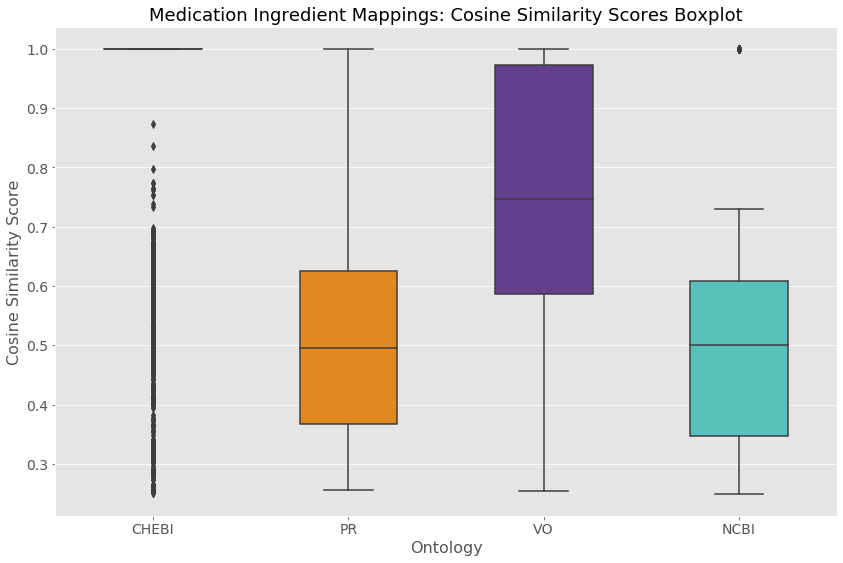

In [194]:
# create plot data
meds_sim_plot = pd.DataFrame({'Ontology':['CHEBI'] * len(med_chebi_similarity_scores) + ['PR'] * len(med_pro_similarity_scores) + ['VO'] * len(med_vo_similarity_scores) + ['NCBI'] * len(med_ncbitaxon_similarity_scores),
                              'Similarity_Score': med_chebi_similarity_scores + med_pro_similarity_scores + med_vo_similarity_scores + med_ncbitaxon_similarity_scores})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='Similarity_Score', x='Ontology', data=meds_sim_plot, width=0.5, palette=my_pal)
    
plt.title('Medication Ingredient Mappings: Cosine Similarity Scores Boxplot', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Cosine Similarity Score', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()


***

**Click [here](#drug-mapping-results) to return to the Drug Exposure Ingredient Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

### Measurements <a class="anchor" id="mapping-labs"></a>

***

**SQL Queries**  
- [x] CHCO Measurements Used in Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_measurements-sql))  


**Data Description:**  
Two types of data were combined prior to performing mapping on this domain. The first wave of data was pulled from `CHCO` and like with the condition and measurement domains, contains only those concepts that were used at least once in clinical practice. This set contained a total of `1,606` LOINC concepts or `4,358` lab test results (more information on how lab test results were identified below). The initial set of `CHCO` data were supplemented by adding the latest `LOINC2HPO` annotations. The current annotation set ([annotations.tsv](https://github.com/TheJacksonLaboratory/loinc2hpoAnnotation/blob/develop/Data/TSVSingleFile/annotations.tsv); last updated `06/07/2020`) was downloaded from the develop branch of the [LOINC2HPO GitHub repository](https://github.com/TheJacksonLaboratory/loinc2hpoAnnotation) on `08/12/2020`). Of the `3,119` unique codes obtained from `LOINC2HPO` (`7,421` unique results), `631` overlapped with the `OMOP` measurement terms retrieved from `CHCO` and were excluded. The final set of processed terms included `2,488` unique LOINC concepts or `6,890` lab test results. 

*Identifying LOINC Scale and Result Type*  
All lab test scale types (i.e. ordinal, nominal, quantitative, qualitative, narrative, doc, and panel) were initially eligible to be mapped. The scale type of each lab test was identified by parsing the free-text text in the concept synonym field for the presence of any of the scale types listed above. Result type was identified using a two-step approach. First, we analyzed the reference ranges available in the patient data. If at least one numeric result was reported the result type was recorded as `Normal/Low/High` and if a `positive` or `negative` result was reported it was recorded as `Positive/Negative`. Then, for all lab tests without a reference range in the data, the result type was obtained by parsing the free-text in the concept synonym field. For all tests with an ordinal scale type, if the keywords `presence` or `screen` were identified, the result type was reported as `Positive/Negative`. All tests with a quantitative scale type were given the result type `Normal/Low/High`. All other scale types were annotated with `Unknown Result Type`. 


**CHCO Data:**
- <u>Scale types</u>: `1,320` quantitative, `192` ordinal, `66` nomimal, `24` narratives, `2` panel, `1` document and `1` Other  
- <u>Result types</u>: `1,306` Normal/Low/High, `220` Negative/Positive, and `80` Unknown  
- <u>Concept-Level Results</u>: `1,606` source codes, `1,606` labels, and `41,891` synonyms using `LOINC` and `PEDSnet`   
- <u>Ancestor-Level Results</u>: `20,781` source codes and `21,1191` labels using `LOINC`  

**LOINC2HPO Data:**  
- <u>Scale types</u>: `1,895` quantitative, `574` ordinal, `17` nomimal, `1` narratives, and `1` panel
- <u>Result types</u>: `1,914` Normal/Low/High, `574` Negative/Positive, and `80` Unknown 
- <u>Concept-Level Results</u>: `2,488` source codes, `2,488` labels, and `73,932` synonyms using `LOINC`  
- <u>Ancestor-Level Results</u>: `23,468` source codes and `24,317` labels using `LOINC`  


**Ontology Data:**  
`OMOP` Measurement concept ids were mapped to:  
- Phenotypes ([Human Phenotype Ontology (HPO)](https://hpo.jax.org/)) 
- Anatomical entities ([Uber-Anatomy Ontology (UBERON)](http://uberon.org/))   
- Organisms ([NCBI Organism Taxonomy (NCBITaxon)](https://www.ncbi.nlm.nih.gov/taxonomy))  
- Proteins ([Protein Ontology (PRO)](https://proconsortium.org/))  
- Chemicals, hormones, and enzymes ([Chemical Entities of Biological Interest (CHEBI)](https://www.ebi.ac.uk/chebi/))
- Cells ([Cell Ontology (CL)](https://github.com/obophenotype/cell-ontology))  


**CLINICAL MAPPING DATA**

In [63]:
# load data used for mapping
measurement_data = pd.read_csv(measurements, sep=',', header=0)
measurement_data.fillna('', inplace=True)

# view data
measurement_data.head()

,SOURCE,CONCEPT_ID,CONCEPT_SOURCE_CODE,CONCEPT_LABEL,CONCEPT_VOCAB,CONCEPT_VOCAB_VERSION,CONCEPT_SYNONYM,ANCESTOR_CONCEPT_ID,ANCESTOR_SOURCE_CODE,ANCESTOR_LABEL,ANCESTOR_VOCAB,ANCESTOR_VOCAB_VERSION,SCALE,RESULT_TYPE
0,LOINC2HPO,3009759,loinc:4543-5,Haptoglobin [Mass/volume] in Serum or Plasma b...,LOINC,LOINC 2.64,Elec | Elect | Electr | Electro | Electrophhrs...,3009759 | 40779561 | 45876009 | 40792793 | 362...,loinc:4543-5 | loinc:LP30786-5 | loinc:HEM/BC ...,Haptoglobin [Mass/volume] in Serum or Plasma b...,LOINC,LOINC2HPO,QUANT,Normal/Low/High
1,LOINC2HPO,42868683,loinc:70209-2,Haptoglobin [Moles/volume] in Serum or Plasma,LOINC,LOINC 2.64,Haptoglobin [Moles/volume] in Serum or Plasma ...,40779561 | 40792793 | 40779565 | 45876009 | 42...,loinc:LP30786-5 | loinc:LP31756-7 | loinc:LP30...,Hematology | Abnormal Hemoglobin | Hematology ...,LOINC,LOINC2HPO,QUANT,Normal/Low/High
2,LOINC2HPO,3012336,loinc:4542-7,Haptoglobin [Mass/volume] in Serum or Plasma,LOINC,LOINC 2.64,Haptoglob | HEMATOLOGY/CELL COUNTS | HP | Hpt ...,45876033 | 45876249 | 3048564 | 40777640 | 458...,loinc:PANEL.CHEM | loinc:PANEL | loinc:48796-7...,Chemistry order set | Order set | Hepatitis C ...,LOINC,LOINC2HPO,QUANT,Normal/Low/High
3,CHCO,40771570,loinc:69049-5,Coagulation specialist review of results,LOINC,LOINC 2.64,Coag | Impression | Impression/interpretation ...,36208195 | 40771570 | 36206173 | 45876017,loinc:LP248770-2 | loinc:69049-5 | loinc:MISC ...,Lab terms not yet categorized | Coagulation sp...,LOINC,LOINC 2.64,NAR,Negative/Positive
4,CHCO,3005089,loinc:21709-1,MTHFR gene mutations found [Identifier] in Blo...,LOINC,LOINC 2.64,"5,10-methylenetetrahydrofolate reductase gene ...",40796129 | 40772960 | 45876022 | 40796026 | 45...,loinc:MOLPATH.MUT | loinc:LP19739-9 | loinc:MO...,MTHFR gene mutations found [Identifier] in Blo...,LOINC,LOINC 2.64,NOM,Negative/Positive


In [64]:
# get stats
total_concepts = len(measurement_data)

# split results by concept type (i.e. concepts used in practice, standard concepts)
concepts_grp = measurement_data.groupby('SOURCE')

# split stacked data by concept type
concepts_grp_chco = concepts_grp.get_group('CHCO').drop_duplicates()
concepts_grp_l2hpo = concepts_grp.get_group('LOINC2HPO').drop_duplicates()

In [75]:
# concepts
# src codes
chco_con_src_code = [x for y in concepts_grp_chco['CONCEPT_SOURCE_CODE'] for x in y.split(' | ')]
l2hpo_con_src_code = [x for y in concepts_grp_l2hpo['CONCEPT_SOURCE_CODE'] for x in y.split(' | ')]
# src labels
chco_con_lab_code = [x for y in concepts_grp_chco['CONCEPT_LABEL'] for x in y.split(' | ')]
l2hpo_con_lab_code = [x for y in concepts_grp_l2hpo['CONCEPT_LABEL'] for x in y.split(' | ')]
# src synonym
chco_con_syn_code = [x for y in concepts_grp_chco['CONCEPT_SYNONYM'] for x in y.split(' | ')]
l2hpo_con_syn_code = [x for y in concepts_grp_l2hpo['CONCEPT_SYNONYM'] for x in y.split(' | ')]
# vocab
chco_con_vocab_code = ', '.join(set([x for y in concepts_grp_chco['CONCEPT_VOCAB'] for x in y.split(' | ')]))
l2hpo_con_vocab_code = ', '.join(set([x for y in concepts_grp_l2hpo['CONCEPT_VOCAB'] for x in y.split(' | ')]))

# ancestors
# concept ids
chco_anc_ids = [x for y in concepts_grp_chco['ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
l2hpo_anc_ids = [x for y in concepts_grp_l2hpo['ANCESTOR_CONCEPT_ID'] for x in y.split(' | ')]
# src codes
chco_anc_src_code = [x for y in concepts_grp_chco['ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
l2hpo_anc_src_code = [x for y in concepts_grp_l2hpo['ANCESTOR_SOURCE_CODE'] for x in y.split(' | ')]
# src labels
chco_anc_lab_code = [x for y in concepts_grp_chco['ANCESTOR_LABEL'] for x in y.split(' | ')]
l2hpo_anc_lab_code = [x for y in concepts_grp_l2hpo['ANCESTOR_LABEL'] for x in y.split(' | ')]
# vocab
chco_anc_vocab_code = ', '.join(set([x for y in concepts_grp_chco['ANCESTOR_VOCAB'] for x in y.split(' | ')]))
l2hpo_anc_vocab_code = ', '.join(set([x for y in concepts_grp_l2hpo['ANCESTOR_VOCAB'] for x in y.split(' | ')]))


*CHCO Data*

In [65]:
chco_concepts = len(set(concepts_grp_chco['CONCEPT_ID']))
chco_scale_counts = concepts_grp_chco.groupby(['SCALE']).size()
chco_result_type_counts = concepts_grp_chco.groupby(['RESULT_TYPE']).size()

In [66]:
res1 = 'There are {} CHCO LOINC concepts'.format(chco_concepts)
res2 = '\nScale types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in chco_scale_counts.to_dict().items()]))
res3 = '\nResult types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in chco_result_type_counts.to_dict().items()]))

print(res1, res2, res3)

There are 1606 CHCO LOINC concepts 
Scale types: DOC (n=1), NAR (n=24), NOM (n=66), ORD (n=192), Other (n=1), PNL (n=2), QUANT (n=1320) 
Result types: Negative/Positive (n=220), Normal/Low/High (n=1306), Unknown Result Type (n=80)


In [76]:
# print CHCO data
res1 = 'There were {} CHCO concepts that could be mapped'.format(len(concepts_grp_chco))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(chco_con_src_code),
                                                                                           len(chco_con_lab_code),
                                                                                           len(chco_con_syn_code))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(chco_con_vocab_code)
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(chco_anc_ids),
                                                                                                    len(chco_anc_src_code),
                                                                                                    len(chco_anc_lab_code))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(chco_anc_vocab_code)

print(res1, res2, res3, res4, res5)


There were 1606 CHCO concepts that could be mapped 
At the concept-level, there were 1606 source codes, 1606 labels, and 41891 synonyms 
Concept-level data came from the following vocabularies: LOINC, PEDSnet 

At the ancestor-level, there were 20781 concept ids, 20781 source codes and 21191 labels 
Ancestor-level data came from the following vocabularies: LOINC, 


*LOINC2HPO Data*

In [67]:
l2h_concepts = len(set(concepts_grp_l2hpo['CONCEPT_ID']))
l2h_scale_counts = concepts_grp_l2hpo.groupby(['SCALE']).size()
l2h_result_type_counts = concepts_grp_l2hpo.groupby(['RESULT_TYPE']).size()

In [68]:
res1 = 'There are {} LOINC2HPO LOINC concepts'.format(l2h_concepts)
res2 = '\nScale types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in l2h_scale_counts.to_dict().items()]))
res3 = '\nResult types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in l2h_result_type_counts.to_dict().items()]))

print(res1, res2, res3)

There are 2488 LOINC2HPO LOINC concepts 
Scale types: NAR (n=1), NOM (n=17), ORD (n=574), PNL (n=1), QUANT (n=1895) 
Result types: Negative/Positive (n=574), Normal/Low/High (n=1914)


In [77]:
# print LOINC2HPO data
res1 = 'There were {} LOINC2HPO concepts that could be mapped'.format(len(concepts_grp_l2hpo))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(l2hpo_con_src_code),
                                                                                               len(l2hpo_con_lab_code),
                                                                                               len(l2hpo_con_syn_code))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(l2hpo_con_vocab_code)
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(l2hpo_anc_ids),
                                                                                                    len(l2hpo_anc_src_code),
                                                                                                    len(l2hpo_anc_lab_code))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(l2hpo_anc_vocab_code)

print(res1, res2, res3, res4, res5)


There were 2488 LOINC2HPO concepts that could be mapped 
At the concept-level, there were 2488 source codes, 2488 labels, and 73932 synonyms 
Concept-level data came from the following vocabularies: LOINC 

At the ancestor-level, there were 23468 concept ids, 23468 source codes and 24317 labels 
Ancestor-level data came from the following vocabularies: LOINC, 


<br>

***

#### MAPPING RESULTS  <a class="anchor" id="lab-mapping-results"></a>

***
**Click [here](#lab-mapping-results) to return to the Lab Mapping Results section**  
**Click [here](#mapping-results) to return to the Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**
***

<br>

***
## Mapping Validation <a class="anchor" id="mapping-validation"></a>
***


### Domain Expert Review <a class="anchor" id="expert-review"></a>

***


- [Conditions](#expert-conditions)  
- [Drug Ingredients](#expert-drugs)  
- [Measurements](#expert-labs) 


#### Conditions <a class="anchor" id="expert-conditions"></a>



#### Drug Ingredients <a class="anchor" id="expert-drugs"></a>



#### Measurements <a class="anchor" id="expert-labs"></a>


***

**Click [here](#toc) to return to the Table of Contents**

***

<br>

### Coverage Study <a class="anchor" id="coverage-study"></a>

***

- [Conditions](#coverage-conditions)  
- [Drug Ingredients](#coverage-drugs)  
- [Measurements](#coverage-labs) 


In [214]:
def gets_group_stats(prim_data: pd.DataFrame, sec_data: pd.DataFrame, grp_col: str, concept_col: str) -> dict:
    """

    Args:
        prim_data:
        sec_data:
        grp_col:
        concept_col:

    Returns:

    """

    # preprocess data
    # secondary data
    sec_data.fillna(0, inplace=True)
    sec_count_col = [x for x in sec_data.columns if 'count' in x.lower()][0]
    sec_concepts = set(sec_data[concept_col])
    sec_dict = {x[0]: int(x[1]) for x in list(zip(list(sec_data[concept_col]), list(sec_data[sec_count_col])))}
    # primary data
    prim_count_col = [x for x in prim_data.columns if 'count' in x.lower()][0]
    prim_data_grps = prim_data.groupby(grp_col)
    print('Processing {} Database groups'.format(len(prim_data_grps.groups.keys())))

    # loop over each database and compare against secondary data
    db_compared_data = {}
    for grp in tqdm(prim_data_grps.groups.keys()):
        db_compared_data[grp] = {}
        print('Processing Database: {}'.format(grp))
        # get group data
        db_df = prim_data_grps.get_group(grp)
        # create dictionary out of concepts and counts
        prim_dict = {x[0]: x[1] for x in list(zip(list(db_df[concept_col]), list(db_df[prim_count_col])))}
        # get coverage data
        overlap = set(prim_dict.keys()).intersection(sec_concepts)
        prim_only = set(prim_dict.keys()).difference(sec_concepts)
        sec_only = sec_concepts.difference(set(prim_dict.keys()))
        # save output to dict
        db_compared_data[grp]['overlap'] = {x: prim_dict[x] for x in overlap}
        db_compared_data[grp]['primary_only'] = {x: prim_dict[x] for x in prim_only}
        db_compared_data[grp]['secondary_only'] = {x: sec_dict[x] for x in sec_only}

    return db_compared_data


#### CHCO Concept Frequency Data


In [196]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Conditions']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,760841,Conditions,1,100
1,4122179,Conditions,1,100
2,4254374,Conditions,1,100
3,4341363,Conditions,1,100
4,436140,Conditions,1,100


#### OHDSI Concept Prevalence Data


In [210]:
# load concet prevalence data
concept_prev_conds = pd.read_excel(coverage_data, sheet_name='Condition_Occurrence_Concepts', sep=',', header=0)
concept_prev_conds.fillna('', inplace=True)

# get only SNOMED concepts
concept_prev_conds = concept_prev_conds[concept_prev_conds['VOCAB (TJC)'] =='SNOMED']

# approved databases
concept_prev_conds = concept_prev_conds[concept_prev_conds.['ANALYSIS APPROVED  (TJC)'] == 1]

# view data
concept_prev_conds.head(n=5)


,CONCEPT_ID,CONCEPT_NAME,DOMAIN (TJC),STANDARD (TJC),VOCAB (TJC),DATABASE_NAME,RECORD_COUNT,ANALYSIS APPROVED (TJC)
0,22274,Neoplasm of uncertain behavior of larynx,Condition,Standard,SNOMED,Ajou_university,100,1
1,22288,Hereditary elliptocytosis,Condition,Standard,SNOMED,Ajou_university,100,1
2,22340,Esophageal varices without bleeding,Condition,Standard,SNOMED,Ajou_university,1720,1
3,22350,Edema of larynx,Condition,Standard,SNOMED,Ajou_university,1817,1
4,22426,Congenital macrostomia,Condition,Standard,SNOMED,Ajou_university,100,1


#### Conditions <a class="anchor" id="coverage-conditions"></a>


In [359]:
# load data
cond_mappings = pd.read_excel(conds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
cond_mappings.fillna('', inplace=True)

# merge concept counts
cond_mappings = cond_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# get only standard concepts that have been mapped to at least 1 ontology
not_standard = cond_mappings.query('STANDARD != "S"')
not_mapped = cond_mappings.query('HP_URI == "NOT YET MAPPED" & MONDO_URI == "NOT YET MAPPED"')

cond_mappings_standard = cond_mappings_counts[~cond_mappings.CONCEPT_ID.isin(not_standard['CONCEPT_ID']) &
                                              ~cond_mappings.CONCEPT_ID.isin(not_mapped['CONCEPT_ID'])]

# keep only needed columns
cond_mappings_standard = cond_mappings_standard[['CONCEPT_ID', 'CONCEPT_LABEL', 'CONCEPT_TYPE', 'CONCEPT_COUNT']]

cond_mappings_standard.head()


,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_TYPE,CONCEPT_COUNT
0,22274,Neoplasm of uncertain behavior of larynx,Concept used in Practice,7.0
1,22281,Hb SS disease,Concept used in Practice,3917.0
2,22288,Hereditary elliptocytosis,Concept used in Practice,83.0
3,22340,Esophageal varices without bleeding,Concept used in Practice,517.0
4,22350,Edema of larynx,Concept used in Practice,1244.0


In [211]:
print('There are {} `OMOP` concept ids covered by `HPO` or `MONDO` mappings via `OMOP2OBO` mappings'.format(len(cond_mappings_standard)))

There are 81945 `OMOP` concept ids covered by `HPO` or `MONDO` mappings via `OMOP2OBO` mappings


In [242]:
cp_cond_concepts = set(list(concept_prev_conds['CONCEPT_ID']))
omop2obo_cond_concepts = set(list(cond_mappings_standard['CONCEPT_ID']))

# get general coverage across all Concept Prevalance databases
overlap_cond_concepts = cp_cond_concepts.intersection(omop2obo_cond_concepts)
only_omop2obo_cond_concepts = omop2obo_cond_concepts.difference(cp_cond_concepts)
only_cp_cond_concepts = cp_cond_concepts.difference(omop2obo_cond_concepts)


In [244]:
cond_coverage = 'The `OMOP2OBO` mappings covered {}% of the {} Concept Prevalance concepts'.format(round(len(overlap_cond_concepts)/(len(overlap_cond_concepts) + len(only_cp_cond_concepts))*100, 3),
                                                                                                   len(cp_cond_concepts))
omop2obo_only = '\nThere are {} concepts in `OMOP2OBO` that are not in the Concept Prevalance concept set'.format(len(only_omop2obo_cond_concepts))
cp_only = '\nThere are {} concepts in the Concept Prevalance concept set that are not in `OMOP2OBO'.format(len(only_cp_cond_concepts))

print(cond_coverage, omop2obo_only, cp_only)


The `OMOP2OBO` mappings covered 87.607% of the 62335 Concept Prevalance concepts 
There are 27335 concepts in `OMOP2OBO` that are not in the Concept Prevalance concept set 
There are 7725 concepts in the Concept Prevalance concept set that are not in `OMOP2OBO


*DATABASE STATISTICS*

In [246]:
# generate coverage dictionary
conds_coverage_dict = gets_group_stats(concept_prev_conds.copy(), cond_mappings_standard.copy(),
                                       'DATABASE_NAME', 'CONCEPT_ID')

# convert dictionary to data frame


Processing 24 Database groups


In [241]:
# create contingency table
dbs = list(conds_coverage_dict.keys())
db_covered = [len(conds_coverage_dict[j]['overlap'].keys()) for j in dbs]
db_not_covered = [len(conds_coverage_dict[j]['primary_only'].keys()) for j in dbs]

conds_coverage_df = pd.DataFrame({'Database': dbs,
                                 'Coverage_Yes': db_covered,
                                 'Coverage_No': db_not_covered})

conds_coverage_df['%Coverage'] = round(conds_coverage_df['Coverage_Yes']/(conds_coverage_df['Coverage_Yes'] + conds_coverage_df['Coverage_No'])*100, 3)

# view table
conds_coverage_df


,Database,Coverage_Yes,Coverage_No,%Coverage
0,Ajou_university,5831,224,96.301
1,AmbEMR,44563,3972,91.816
2,Australia_JJ,3408,128,96.380
3,DA_France,3313,58,98.279
4,DA_Germany,6316,327,95.078
5,HCUP,9034,287,96.921
6,Hospital,15104,602,96.167
7,IBM_CCAE,15222,637,95.983
8,IBM_MDCD,15027,609,96.105
9,IBM_MDCR,14712,526,96.548


In [250]:
# get range of concept frequency for codes not covered by OMOP2OBO
omop2obo_not_covered, cp_not_covered, omop2obo_not_plt, cp_not_plt = [], [], [], []
for grp in conds_coverage_dict.keys():
    
    # cp not in omop2obo
    cp_not = conds_coverage_dict[grp]['primary_only'].values()    
    cp_not_covered.append([grp, min(cp_not), max(cp_not), statistics.median(cp_not)])
    cp_not_plt.append([[grp] * len(cp_not), cp_not])
    
    # omop2obo mot in cp
    omop2obo_not = conds_coverage_dict[grp]['secondary_only'].values()    
    omop2obo_not_covered.append([grp, min(omop2obo_not), max(omop2obo_not), statistics.median(omop2obo_not)])
    omop2obo_not_plt.append([[grp] * len(omop2obo_not), omop2obo_not])

    
    # create pandas dfs
cond_cp_not_covered = pd.DataFrame({'database': [x[0] for x in cp_not_covered],
                                   'min_freq': [x[1] for x in cp_not_covered],
                                   'max_freq': [x[2] for x in cp_not_covered],
                                   'median_freq': [x[3] for x in cp_not_covered]})
    
cond_omop2obo_not_covered = pd.DataFrame({'database': [x[0] for x in omop2obo_not_covered],
                                          'min_freq': [x[1] for x in omop2obo_not_covered],
                                          'max_freq': [x[2] for x in omop2obo_not_covered],
                                          'median_freq': [x[3] for x in omop2obo_not_covered]})
    
    

In [248]:
# concepts not covered by OMOP2OBO
cond_cp_not_covered


,database,min_freq,max_freq,median_freq
0,Ajou_university,100,36210,100.0
1,AmbEMR,100,2086633,100.0
2,Australia_JJ,100,37866,100.0
3,DA_France,100,14430,100.0
4,DA_Germany,100,740188,100.0
5,HCUP,100,279438,100.0
6,Hospital,100,2312481,100.0
7,IBM_CCAE,100,2374275,241.0
8,IBM_MDCD,100,52739431,110.0
9,IBM_MDCR,100,390160,100.0


In [278]:
{k: v for k, v in sorted(conds_coverage_dict['OpenClaims']['primary_only'].items(), key=lambda item: item[1], reverse=True)}



{42537748: 9837914,
 40277917: 7337686,
 195321: 7311087,
 42538119: 7242961,
 42539502: 6338237,
 42537730: 4704662,
 4211799: 4040102,
 37109843: 3616353,
 35624756: 2671622,
 44783356: 2106046,
 35624757: 1988250,
 72737: 1736453,
 35622934: 1636057,
 42538117: 1218131,
 4141640: 1145919,
 40400785: 1135141,
 46269755: 1016990,
 4084768: 932448,
 46269752: 914852,
 45757639: 886129,
 35624485: 657149,
 42537744: 570192,
 46270564: 515676,
 35623051: 497553,
 4098597: 423598,
 35622759: 385028,
 40548161: 339860,
 4081173: 298473,
 35625971: 295804,
 35622958: 248933,
 4088588: 236284,
 76002: 230714,
 443521: 179475,
 444125: 167642,
 4009573: 157186,
 4064437: 150629,
 78818: 142764,
 440167: 132623,
 37117206: 130024,
 436480: 129731,
 434436: 126028,
 77615: 120863,
 4176969: 117314,
 35615055: 116686,
 45763587: 110434,
 42537741: 105844,
 4063163: 100009,
 45757504: 96357,
 4111720: 95187,
 4122735: 92451,
 4028644: 88611,
 35624169: 79602,
 35610112: 76480,
 45757381: 76331,
 

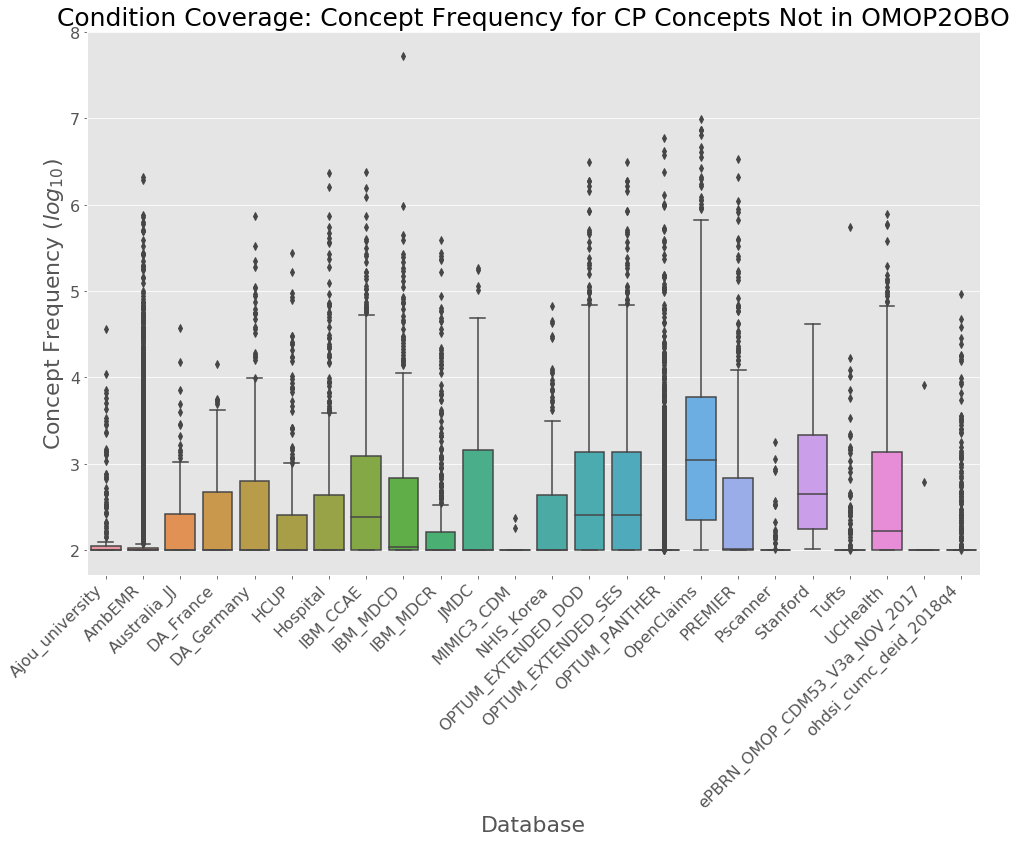

In [276]:
# create plot data
omop_not_cond_plot = pd.DataFrame({'database': [x for y in cp_not_plt for x in y[0]],
                                   'concept_frequency': [math.log10(x) for y in cp_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=omop_not_cond_plot)

sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Condition Coverage: Concept Frequency for CP Concepts Not in OMOP2OBO', fontsize=25)
plt.suptitle("")
plt.xlabel('Database', fontsize=22)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=22)
plt.tick_params(labelsize=16)
plt.show()



In [249]:
# concepts in OMOP2OBO, but not in CP
cond_omop2obo_not_covered


,database,min_freq,max_freq,median_freq
0,Ajou_university,0,471512,0.0
1,AmbEMR,0,114901,0.0
2,Australia_JJ,0,471512,0.0
3,DA_France,0,471512,0.0
4,DA_Germany,0,471512,0.0
5,HCUP,0,202085,0.0
6,Hospital,0,114901,0.0
7,IBM_CCAE,0,114901,0.0
8,IBM_MDCD,0,114901,0.0
9,IBM_MDCR,0,114901,0.0


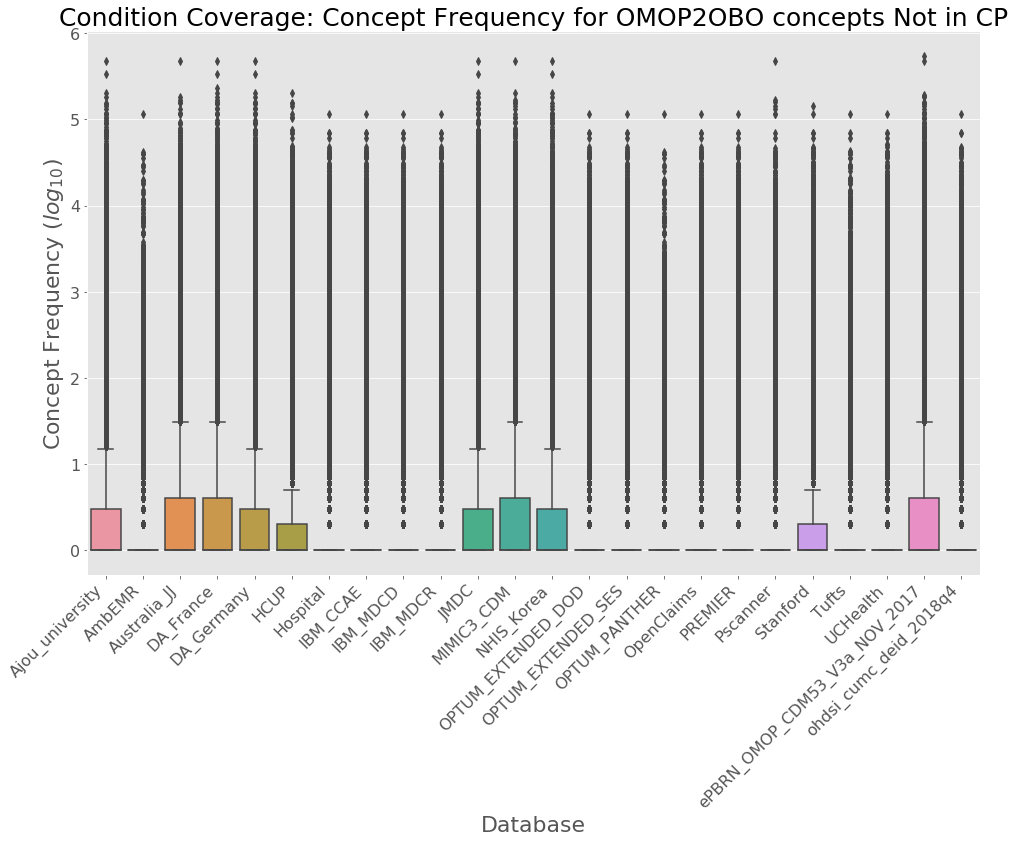

In [275]:
# create plot data
cp_not_cond_plot = pd.DataFrame({'database': [x for y in omop2obo_not_plt for x in y[0]],
                                 'concept_frequency': [math.log10(x) if x > 1 else 0 for y in omop2obo_not_plt for x in y[1]]})

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sboxplot = sns.boxplot(y='concept_frequency', x='database', data=cp_not_cond_plot)

sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Condition Coverage: Concept Frequency for OMOP2OBO concepts Not in CP', fontsize=25)
plt.suptitle("")
plt.xlabel('Database', fontsize=22)
plt.ylabel('Concept Frequency ($log_{10}$)', fontsize=22)
plt.tick_params(labelsize=16)
plt.show()



In [240]:
# get ontology overlap for lists



6055

In [231]:
conds_coverage_dict.keys()

dict_keys(['Ajou_university', 'AmbEMR', 'Australia_JJ', 'DA_France', 'DA_Germany', 'HCUP', 'Hospital', 'IBM_CCAE', 'IBM_MDCD', 'IBM_MDCR', 'JMDC', 'MIMIC3_CDM', 'NHIS_Korea', 'OPTUM_EXTENDED_DOD', 'OPTUM_EXTENDED_SES', 'OPTUM_PANTHER', 'OpenClaims', 'PREMIER', 'Pscanner', 'Stanford', 'Tufts', 'UCHealth', 'ePBRN_OMOP_CDM53_V3a_NOV_2017', 'ohdsi_cumc_deid_2018q4'])

In [245]:
from tqdm import tqdm

def gets_group_stats(prim_data: pd.DataFrame, sec_data: pd.DataFrame, grp_col: str, concept_col: str) -> dict:
    """

    Args:
        prim_data:
        sec_data:
        grp_col:
        concept_col:

    Returns:

    """

    # preprocess data
    # secondary data
    sec_data.fillna('0', inplace=True)
    sec_count_col = [x for x in sec_data.columns if 'count' in x.lower()][0]
    sec_concepts = set(sec_data[concept_col])
    sec_dict = {x[0]: int(x[1]) if x[1] != '' else 0 for x in list(zip(list(sec_data[concept_col]),
                                                                       list(sec_data[sec_count_col])))}
    # primary data
    prim_count_col = [x for x in prim_data.columns if 'count' in x.lower()][0]
    prim_data_grps = prim_data.groupby(grp_col)
    print('Processing {} Database groups'.format(len(prim_data_grps.groups.keys())))

    # loop over each database and compare against secondary data
    db_compared_data = {}
    for grp in prim_data_grps.groups.keys():
        db_compared_data[grp] = {}
#         print('\nProcessing Database: {}'.format(grp))
        # get group data
        db_df = prim_data_grps.get_group(grp)
        # create dictionary out of concepts and counts
        prim_dict = {x[0]: x[1] for x in list(zip(list(db_df[concept_col]), list(db_df[prim_count_col])))}
        # get coverage data
        overlap = set(prim_dict.keys()).intersection(sec_concepts)
        prim_only = set(prim_dict.keys()).difference(sec_concepts)
        sec_only = sec_concepts.difference(set(prim_dict.keys()))
        # save output to dict
        db_compared_data[grp]['all_concepts'] = set(prim_dict.keys())
        db_compared_data[grp]['overlap'] = {x: prim_dict[x] for x in overlap}
        db_compared_data[grp]['primary_only'] = {x: prim_dict[x] for x in prim_only}
        db_compared_data[grp]['secondary_only'] = {x: sec_dict[x] for x in sec_only}

    return db_compared_data

#### Drug Ingredients <a class="anchor" id="coverage-drugs"></a>



#### Measurements <a class="anchor" id="coverage-labs"></a>



***

### Click [here](#toc) to return to the Table of Contents

***

<br>

### Logical Validation <a class="anchor" id="logical-eval"></a>

***
    

***

**Click [here](#toc) to return to the Table of Contents**

***